<a href="https://colab.research.google.com/github/dalexsuam/ECG_DEEP_LEARNING/blob/main/ThreeBranchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
# --------------------------------------------------------------------------------
# IMPORT LIBRARIES
# --------------------------------------------------------------------------------

from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple
from google.colab import drive

# --------------------------------------------------------------------------------
# CONSTANTS
# --------------------------------------------------------------------------------

FS = 500  # Sampling frequency
LEAD_II_INDEX = 1  # Index for Lead II (typically the 2nd lead)
BEAT_LENGTH_SAMPLES = 500  # Length for segmented beats

In [112]:
# --------------------------------------------------------------------------------
# 1. ECG SIGNAL PROCESSING FUNCTIONS
# --------------------------------------------------------------------------------

def apply_bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=FS, order=5):
    """Applies a Butterworth bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq=50.0, fs=FS, Q=30):
    """Applies a 50Hz Notch filter to remove powerline noise."""
    nyq = 0.5 * fs
    w0 = notch_freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

def preprocess_signal(ecg: np.ndarray) -> np.ndarray:
    """Applies per-lead Z-score normalization to the already-filtered signal."""
    ecg = ecg.copy()
    for i in range(ecg.shape[1]):
        ecg[:, i] = (ecg[:, i] - np.mean(ecg[:, i])) / (np.std(ecg[:, i]) + 1e-6)
    return ecg

def r_peak_detection_and_segmentation(ecg_12_leads: np.ndarray, fs: int = FS) -> np.ndarray:
    """Detects R-peaks, segments beats, and returns the average beat morphology."""
    lead_for_detection = ecg_12_leads[:, LEAD_II_INDEX]

    diff_signal = np.diff(lead_for_detection)**2
    window_size = int(0.150 * fs)
    integrated_signal = np.convolve(diff_signal, np.ones(window_size)/window_size, mode='same')

    distance_min = int(0.3 * fs)
    peak_threshold = np.max(integrated_signal) * 0.4
    r_peaks_idx, _ = find_peaks(integrated_signal, height=peak_threshold, distance=distance_min)

    all_beats = []
    half_beat = BEAT_LENGTH_SAMPLES // 2

    for r_idx in r_peaks_idx:
        start_idx = r_idx - half_beat
        end_idx = r_idx + half_beat
        if start_idx >= 0 and end_idx <= ecg_12_leads.shape[0]:
            beat = ecg_12_leads[start_idx:end_idx, :]
            all_beats.append(beat)

    if not all_beats:
        return np.zeros((12, BEAT_LENGTH_SAMPLES), dtype=np.float32)

    segmented_ecg = np.array(all_beats, dtype=np.float32)
    segmented_ecg = np.transpose(segmented_ecg, (0, 2, 1))

    representative_ecg = np.mean(segmented_ecg, axis=0)
    return representative_ecg

In [113]:
# --------------------------------------------------------------------------------
# 2. TABULAR FEATURE ENGINEERING AND PROCESSING
# --------------------------------------------------------------------------------

def tabular_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Creates BMI and BSA, and cleans initial outliers."""
    df = df.copy()
    df.loc[(df['age_at_exam'] < 0.0) | (df['age_at_exam'] > 100.0), 'age_at_exam'] = np.nan
    df.loc[(df['trainning_load'] <= 0.0) | (df['trainning_load'] > 4.0), 'trainning_load'] = np.nan

    df['height_m'] = df['height'] / 100.0
    df['BMI'] = df['weight'] / (df['height_m']**2)
    df['BSA'] = np.sqrt((df['height'] * df['weight']) / 3600.0)

    df = df.drop(columns=['height', 'height_m'])
    return df

class TabularProcessor:
    """Handles Iterative Imputation, StandardScaler, and OneHotEncoder."""
    def __init__(self, numerical_features: List[str], categorical_features: List[str]):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.imputer = IterativeImputer(max_iter=10, random_state=42)
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, df: pd.DataFrame):
        numerical_data_train = df[self.numerical_features].values
        self.imputer.fit(numerical_data_train)
        imputed_data_train = self.imputer.transform(numerical_data_train)
        self.scaler.fit(imputed_data_train)
        categorical_data_train = df[self.categorical_features].astype(str).values
        self.encoder.fit(categorical_data_train)

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        numerical_data = df[self.numerical_features].values
        imputed_data = self.imputer.transform(numerical_data)
        scaled_data = self.scaler.transform(imputed_data)
        categorical_data = df[self.categorical_features].astype(str).values
        encoded_data = self.encoder.transform(categorical_data)
        return np.concatenate([scaled_data, encoded_data], axis=1)

In [114]:
# --------------------------------------------------------------------------------
# 3. THREE BRANCH CNN MODEL
# --------------------------------------------------------------------------------

class ThreeBranchCNNModel(nn.Module):
    def __init__(self, num_leads=12, beat_length=500, tabular_input_size=18):
        super(ThreeBranchCNNModel, self).__init__()

        # Branch 1: Raw Signal Processing
        self.raw_branch = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.AdaptiveAvgPool1d(1)
        )

        # Branch 2: Beat Morphology Processing
        self.beat_branch = nn.Sequential(
            nn.Conv1d(num_leads, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # Branch 3: Tabular Data Processing
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Combined Classifier
        combined_features = 128 + 128 + 32  # raw_branch + beat_branch + tabular_branch
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, raw_signal, beat_morphology, tabular_data):
        # Process raw signal
        raw_features = self.raw_branch(raw_signal)
        raw_features = raw_features.view(raw_features.size(0), -1)

        # Process beat morphology
        beat_features = self.beat_branch(beat_morphology)
        beat_features = beat_features.view(beat_features.size(0), -1)

        # Process tabular data
        tabular_features = self.tabular_branch(tabular_data)

        # Combine all features
        combined_features = torch.cat([raw_features, beat_features, tabular_features], dim=1)

        # Final classification
        output = self.classifier(combined_features)
        return output

In [115]:
# --------------------------------------------------------------------------------
# 4. DATASET CLASS
# --------------------------------------------------------------------------------

class ThreeBranchECGDataset(Dataset):
    def __init__(self, raw_signals, beat_morphologies, tabular_features, labels):
        # Raw signals: (N, 5000, 12) -> transponer a (N, 12, 5000)
        self.raw_signals = torch.tensor(raw_signals, dtype=torch.float32).permute(0, 2, 1)

        # Beat morphologies: (N, 12, 500) -> ya está en la forma correcta (N, 12, 500)
        self.beat_morphologies = torch.tensor(beat_morphologies, dtype=torch.float32)

        # Tabular features: (N, tabular_feature_size)
        self.tabular_features = torch.tensor(tabular_features, dtype=torch.float32)

        # Labels
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.raw_signals[idx],
                self.beat_morphologies[idx],
                self.tabular_features[idx],
                self.labels[idx])

In [116]:
from google.colab import drive

drive.mount("/content/drive")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# --------------------------------------------------------------------------------
# 5. DATA LOADING AND PREPROCESSING
# --------------------------------------------------------------------------------

# Load data
ECG_folder = "/content/drive/MyDrive/WP_02_data/1_batch_extracted"
ECG_folder_2batch = "/content/drive/MyDrive/WP_02_data/2_batch_extracted"

tabular_data = pd.read_excel("/content/drive/MyDrive/WP_02_data/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel("/content/drive/MyDrive/WP_02_data/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# Load and filter ECG signals
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

# Initialize arrays for signals
raw_signals_1 = np.empty((len(ECGs_1), 5000, 12))
raw_signals_2 = np.empty((len(ECGs_2), 5000, 12))
beat_morphologies_1 = np.empty((len(ECGs_1), 12, BEAT_LENGTH_SAMPLES))
beat_morphologies_2 = np.empty((len(ECGs_2), 12, BEAT_LENGTH_SAMPLES))

print("Processing Batch 1...")
for index, ecg_path in enumerate(tqdm(ECGs_1)):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']

    # Apply filtering
    for i in range(12):
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])

    raw_signals_1[index, :, :] = ecg

    # Extract beat morphology
    beat_morphology = r_peak_detection_and_segmentation(ecg)
    beat_morphologies_1[index, :, :] = beat_morphology

print("Processing Batch 2...")
for index, ecg_path in enumerate(tqdm(ECGs_2)):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']

    # Apply filtering
    for i in range(12):
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])

    raw_signals_2[index, :, :] = ecg

    # Extract beat morphology
    beat_morphology = r_peak_detection_and_segmentation(ecg)
    beat_morphologies_2[index, :, :] = beat_morphology

# Concatenate batches
raw_signals = np.concatenate([raw_signals_1, raw_signals_2], axis=0)
beat_morphologies = np.concatenate([beat_morphologies_1, beat_morphologies_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print(f"Combined raw signals shape: {raw_signals.shape}")
print(f"Combined beat morphologies shape: {beat_morphologies.shape}")
print(f"Combined tabular shape: {tabular_data.shape}")

Processing Batch 1...


100%|██████████| 191/191 [00:11<00:00, 16.45it/s]


Processing Batch 2...


100%|██████████| 335/335 [00:15<00:00, 21.99it/s]


Combined raw signals shape: (526, 5000, 12)
Combined beat morphologies shape: (526, 12, 500)
Combined tabular shape: (526, 18)


# 1. ThreeBranchCNN

In [118]:
# --------------------------------------------------------------------------------
# 6. MAIN TRAINING LOOP WITH 10-FOLD CROSS VALIDATION (VERSIÓN CORREGIDA)
# --------------------------------------------------------------------------------

# Define feature columns
numerical_features = ['age_at_exam', 'weight', 'trainning_load', 'BMI', 'BSA']
categorical_features = ['sex', 'sport_classification', 'AV block', 'ST abnormality',
                       'Complete BBB', 'Prolonged QTc', 'Uncontrolled hypertension',
                       'Supraventricular arrhythmias', 'Ventricular arrhythmias',
                       'Baseline ECG abnormalities', 'Valvular heart diseases',
                       'Symptomatic patients']

# Apply tabular feature engineering
tabular_data_processed = tabular_feature_engineering(tabular_data)

# Initialize results storage
f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
fpr_list_all_folds = []
tpr_list_all_folds = []

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 50

for fold, (train_index, test_index) in enumerate(strat_kf.split(tabular_data_processed, tabular_data_processed['sport_ability'])):
    print(f"\n{'='*50}")
    print(f"Training Fold {fold + 1}/10")
    print(f"{'='*50}")

    # Split data
    X_train, X_test = tabular_data_processed.iloc[train_index,:], tabular_data_processed.iloc[test_index,:]
    raw_train = raw_signals[train_index,:,:]
    raw_test = raw_signals[test_index,:,:]
    beat_train = beat_morphologies[train_index,:,:]
    beat_test = beat_morphologies[test_index,:,:]

    Y_train = X_train['sport_ability']
    Y_test = X_test['sport_ability']

    # Prepare tabular features
    X_train_final = X_train.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = X_test.drop(columns=['sport_ability', 'ECG_patient_id'])

    # Initialize and fit tabular processor
    tabular_processor = TabularProcessor(numerical_features, categorical_features)
    tabular_processor.fit(X_train_final)

    # Transform tabular data
    X_train_tabular = tabular_processor.transform(X_train_final)
    X_test_tabular = tabular_processor.transform(X_test_final)

    # Create datasets
    train_dataset = ThreeBranchECGDataset(raw_train, beat_train, X_train_tabular, Y_train)
    test_dataset = ThreeBranchECGDataset(raw_test, beat_test, X_test_tabular, Y_test)

    # Handle class imbalance
    targets = Y_train.values.astype(int)
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    samples_weights = class_weights[targets]

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).double(),
        num_samples=len(samples_weights),
        replacement=True
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    tabular_input_size = X_train_tabular.shape[1]
    model = ThreeBranchCNNModel(
        num_leads=12,
        beat_length=BEAT_LENGTH_SAMPLES,
        tabular_input_size=tabular_input_size
    ).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Early stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    # Per-fold metrics
    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []
        all_train_outputs = []

        for raw_batch, beat_batch, tabular_batch, labels_batch in train_loader:
            raw_batch = raw_batch.to(device)
            beat_batch = beat_batch.to(device)
            tabular_batch = tabular_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(raw_batch, beat_batch, tabular_batch)
            loss = criterion(outputs.squeeze(), labels_batch.squeeze())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).int()
            all_train_labels.extend(labels_batch.cpu())
            all_train_preds.extend(predicted.cpu())
            all_train_outputs.extend(outputs.cpu())

        avg_train_loss = train_loss / len(train_loader)
        train_loss_single_fold.append(avg_train_loss)

        # Calculate training metrics
        if len(all_train_labels) > 0:
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=0)
            cm = confusion_matrix(all_train_labels, all_train_preds)
            if cm.size == 1:
                train_sensitivity = 0.0
                train_specificity = 0.0
            else:
                tn, fp, fn, tp = cm.ravel()
                train_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                train_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            train_auc = roc_auc_score(all_train_labels, all_train_preds)
        else:
            train_accuracy = 0.0
            train_f1 = 0.0
            train_sensitivity = 0.0
            train_specificity = 0.0
            train_auc = 0.0

        # Testing phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []
        all_test_outputs = []
        all_test_probabilities = []

        with torch.no_grad():
            for raw_batch, beat_batch, tabular_batch, labels_batch in test_loader:
                raw_batch = raw_batch.to(device)
                beat_batch = beat_batch.to(device)
                tabular_batch = tabular_batch.to(device)
                labels_batch = labels_batch.to(device)

                outputs = model(raw_batch, beat_batch, tabular_batch)
                loss = criterion(outputs.squeeze(), labels_batch.squeeze())
                test_loss += loss.item()

                predicted = (outputs.squeeze() > 0.5).int()
                probabilities = outputs.squeeze().cpu().numpy()

                all_test_labels.extend(labels_batch.cpu())
                all_test_preds.extend(predicted.cpu())
                all_test_outputs.extend(outputs.squeeze().cpu())
                all_test_probabilities.extend(probabilities)

        avg_test_loss = test_loss / len(test_loader)
        test_loss_single_fold.append(avg_test_loss)

        # Calculate test metrics
        if len(all_test_labels) > 0:
            test_accuracy = accuracy_score(all_test_labels, all_test_preds) * 100
            test_f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
            cm = confusion_matrix(all_test_labels, all_test_preds)
            if cm.size == 1:
                test_sensitivity = 0.0
                test_specificity = 0.0
            else:
                tn, fp, fn, tp = cm.ravel()
                test_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                test_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            test_auc = roc_auc_score(all_test_labels, all_test_preds)
        else:
            test_accuracy = 0.0
            test_f1 = 0.0
            test_sensitivity = 0.0
            test_specificity = 0.0
            test_auc = 0.0

        # Calculate ROC curve for this epoch
        if len(all_test_labels) > 0 and len(np.unique(all_test_labels)) > 1:
            fpr, tpr, _ = roc_curve(all_test_labels, all_test_probabilities)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
        else:
            fpr_list_single_fold.append(np.array([0, 1]))
            tpr_list_single_fold.append(np.array([0, 1]))

        # Store metrics
        f1_list_single_fold.append(test_f1)
        f1_list_single_fold_train.append(train_f1)
        sensitivity_list_single_fold.append(test_sensitivity)
        sensitivity_list_single_fold_train.append(train_sensitivity)
        specificity_list_single_fold.append(test_specificity)
        specificity_list_single_fold_train.append(train_specificity)
        accuracy_list_single_fold.append(test_accuracy)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold.append(test_auc)
        auc_score_list_single_fold_train.append(train_auc)
        epochs_single_fold.append(epoch)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
            print(f"Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
            print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")

        # Early stopping check
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            trigger_times = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
                break

    # Store best epoch results for this fold (FUERA del loop de epochs)
    if len(f1_list_single_fold) > 0 and len(fpr_list_single_fold) > 0:
        best_epoch_idx = np.argmax(f1_list_single_fold)

        if best_epoch_idx < len(fpr_list_single_fold) and best_epoch_idx < len(tpr_list_single_fold):
            # Guardar FPR/TPR para ROC
            fpr_list_all_folds.append(fpr_list_single_fold[best_epoch_idx])
            tpr_list_all_folds.append(tpr_list_single_fold[best_epoch_idx])

            # Guardar otras métricas
            f1_list_all_folds.append(f1_list_single_fold[best_epoch_idx])
            f1_list_all_folds_train.append(f1_list_single_fold_train[best_epoch_idx])
            sensitivity_list_all_folds.append(sensitivity_list_single_fold[best_epoch_idx])
            sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[best_epoch_idx])
            specificity_list_all_folds.append(specificity_list_single_fold[best_epoch_idx])
            specificity_list_all_folds_train.append(specificity_list_single_fold_train[best_epoch_idx])
            accuracy_list_all_folds.append(accuracy_list_single_fold[best_epoch_idx])
            accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[best_epoch_idx])
            auc_score_list_all_folds.append(auc_score_list_single_fold[best_epoch_idx])
            auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[best_epoch_idx])
            test_loss_all_folds.append(test_loss_single_fold[best_epoch_idx])
            train_loss_all_folds.append(train_loss_single_fold[best_epoch_idx])
            epochs_all_fold.append(epochs_single_fold[best_epoch_idx])

            print(f"\nFold {fold + 1} Completed - Best Test F1: {f1_list_all_folds[-1]:.4f}")
        else:
            print(f"\nFold {fold + 1} - Index out of range for ROC data")
    else:
        print(f"\nFold {fold + 1} - No metrics or ROC data available")


Training Fold 1/10


 10%|█         | 5/50 [00:55<08:08, 10.85s/it]


Epoch 5/50
Train Loss: 0.1896, Test Loss: 0.0641
Train Acc: 93.45%, Test Acc: 98.11%
Train F1: 0.9366, Test F1: 0.9863


 20%|██        | 10/50 [01:47<06:56, 10.42s/it]


Epoch 10/50
Train Loss: 0.1093, Test Loss: 0.0966
Train Acc: 97.04%, Test Acc: 98.11%
Train F1: 0.9688, Test F1: 0.9859


 22%|██▏       | 11/50 [02:08<07:36, 11.69s/it]

Early stopping triggered at epoch 12!

Fold 1 Completed - Best Test F1: 0.9863

Training Fold 2/10



 10%|█         | 5/50 [00:49<07:25,  9.91s/it]


Epoch 5/50
Train Loss: 0.2427, Test Loss: 0.1850
Train Acc: 90.27%, Test Acc: 96.23%
Train F1: 0.9102, Test F1: 0.9722


 20%|██        | 10/50 [01:40<06:46, 10.16s/it]


Epoch 10/50
Train Loss: 0.0888, Test Loss: 0.1136
Train Acc: 97.67%, Test Acc: 96.23%
Train F1: 0.9770, Test F1: 0.9722


 30%|███       | 15/50 [02:32<06:11, 10.61s/it]


Epoch 15/50
Train Loss: 0.0884, Test Loss: 0.0934
Train Acc: 97.46%, Test Acc: 98.11%
Train F1: 0.9737, Test F1: 0.9859


 38%|███▊      | 19/50 [03:23<05:32, 10.73s/it]


Epoch 20/50
Train Loss: 0.0912, Test Loss: 0.1002
Train Acc: 98.10%, Test Acc: 98.11%
Train F1: 0.9797, Test F1: 0.9859
Early stopping triggered at epoch 20!

Fold 2 Completed - Best Test F1: 0.9859

Training Fold 3/10



 10%|█         | 5/50 [00:50<07:31, 10.04s/it]


Epoch 5/50
Train Loss: 0.2094, Test Loss: 0.2769
Train Acc: 93.66%, Test Acc: 88.68%
Train F1: 0.9395, Test F1: 0.9211


 20%|██        | 10/50 [01:41<06:51, 10.28s/it]


Epoch 10/50
Train Loss: 0.1277, Test Loss: 0.1454
Train Acc: 96.62%, Test Acc: 98.11%
Train F1: 0.9684, Test F1: 0.9859


 30%|███       | 15/50 [02:31<05:53, 10.09s/it]


Epoch 15/50
Train Loss: 0.0839, Test Loss: 0.1652
Train Acc: 97.46%, Test Acc: 98.11%
Train F1: 0.9753, Test F1: 0.9859


 32%|███▏      | 16/50 [02:58<06:18, 11.14s/it]

Early stopping triggered at epoch 17!

Fold 3 Completed - Best Test F1: 0.9859

Training Fold 4/10



 10%|█         | 5/50 [00:51<07:38, 10.19s/it]


Epoch 5/50
Train Loss: 0.2315, Test Loss: 0.1386
Train Acc: 92.60%, Test Acc: 90.57%
Train F1: 0.9326, Test F1: 0.9333


 20%|██        | 10/50 [01:41<06:43, 10.09s/it]


Epoch 10/50
Train Loss: 0.1021, Test Loss: 0.0523
Train Acc: 97.46%, Test Acc: 98.11%
Train F1: 0.9761, Test F1: 0.9859


 30%|███       | 15/50 [02:33<06:03, 10.40s/it]


Epoch 15/50
Train Loss: 0.0717, Test Loss: 0.0439
Train Acc: 97.25%, Test Acc: 98.11%
Train F1: 0.9712, Test F1: 0.9863


 32%|███▏      | 16/50 [02:53<06:08, 10.83s/it]

Early stopping triggered at epoch 17!

Fold 4 Completed - Best Test F1: 0.9863

Training Fold 5/10



 10%|█         | 5/50 [00:49<07:24,  9.89s/it]


Epoch 5/50
Train Loss: 0.2144, Test Loss: 0.2358
Train Acc: 92.18%, Test Acc: 90.57%
Train F1: 0.9224, Test F1: 0.9333


 20%|██        | 10/50 [01:40<06:45, 10.15s/it]


Epoch 10/50
Train Loss: 0.1030, Test Loss: 0.1545
Train Acc: 96.19%, Test Acc: 94.34%
Train F1: 0.9605, Test F1: 0.9600


 30%|███       | 15/50 [02:30<05:44,  9.84s/it]


Epoch 15/50
Train Loss: 0.1115, Test Loss: 0.1299
Train Acc: 95.35%, Test Acc: 90.57%
Train F1: 0.9551, Test F1: 0.9315


 40%|████      | 20/50 [03:21<05:05, 10.17s/it]


Epoch 20/50
Train Loss: 0.0859, Test Loss: 0.1776
Train Acc: 96.41%, Test Acc: 94.34%
Train F1: 0.9618, Test F1: 0.9600


 50%|█████     | 25/50 [04:12<04:10, 10.04s/it]


Epoch 25/50
Train Loss: 0.0585, Test Loss: 0.1930
Train Acc: 98.10%, Test Acc: 94.34%
Train F1: 0.9815, Test F1: 0.9600


 60%|██████    | 30/50 [05:04<03:24, 10.24s/it]


Epoch 30/50
Train Loss: 0.0203, Test Loss: 0.1313
Train Acc: 99.58%, Test Acc: 94.34%
Train F1: 0.9958, Test F1: 0.9600


 66%|██████▌   | 33/50 [05:45<02:57, 10.46s/it]

Early stopping triggered at epoch 34!

Fold 5 Completed - Best Test F1: 0.9863

Training Fold 6/10



 10%|█         | 5/50 [00:49<07:29,  9.99s/it]


Epoch 5/50
Train Loss: 0.2039, Test Loss: 0.1106
Train Acc: 91.54%, Test Acc: 96.23%
Train F1: 0.9170, Test F1: 0.9722


 20%|██        | 10/50 [01:40<06:45, 10.15s/it]


Epoch 10/50
Train Loss: 0.1061, Test Loss: 0.0688
Train Acc: 96.41%, Test Acc: 96.23%
Train F1: 0.9655, Test F1: 0.9714


 30%|███       | 15/50 [02:29<05:48,  9.95s/it]


Epoch 15/50
Train Loss: 0.0972, Test Loss: 0.0281
Train Acc: 96.83%, Test Acc: 100.00%
Train F1: 0.9695, Test F1: 1.0000


 40%|████      | 20/50 [03:19<05:00, 10.03s/it]


Epoch 20/50
Train Loss: 0.0863, Test Loss: 0.0117
Train Acc: 97.04%, Test Acc: 100.00%
Train F1: 0.9690, Test F1: 1.0000


 50%|█████     | 25/50 [04:11<04:16, 10.25s/it]


Epoch 25/50
Train Loss: 0.0500, Test Loss: 0.0055
Train Acc: 97.89%, Test Acc: 100.00%
Train F1: 0.9778, Test F1: 1.0000


 60%|██████    | 30/50 [05:00<03:17,  9.88s/it]


Epoch 30/50
Train Loss: 0.0665, Test Loss: 0.0057
Train Acc: 98.10%, Test Acc: 100.00%
Train F1: 0.9799, Test F1: 1.0000


 66%|██████▌   | 33/50 [05:40<02:55, 10.33s/it]

Early stopping triggered at epoch 34!

Fold 6 Completed - Best Test F1: 1.0000

Training Fold 7/10



 10%|█         | 5/50 [00:51<07:42, 10.27s/it]


Epoch 5/50
Train Loss: 0.1574, Test Loss: 0.0960
Train Acc: 95.78%, Test Acc: 96.15%
Train F1: 0.9617, Test F1: 0.9730


 20%|██        | 10/50 [01:41<06:38,  9.96s/it]


Epoch 10/50
Train Loss: 0.1324, Test Loss: 0.0264
Train Acc: 96.20%, Test Acc: 98.08%
Train F1: 0.9651, Test F1: 0.9863


 30%|███       | 15/50 [02:33<05:59, 10.26s/it]


Epoch 15/50
Train Loss: 0.0884, Test Loss: 0.0455
Train Acc: 97.05%, Test Acc: 98.08%
Train F1: 0.9719, Test F1: 0.9863


 40%|████      | 20/50 [03:26<05:15, 10.53s/it]


Epoch 20/50
Train Loss: 0.0624, Test Loss: 0.0161
Train Acc: 97.47%, Test Acc: 100.00%
Train F1: 0.9741, Test F1: 1.0000


 50%|█████     | 25/50 [04:18<04:24, 10.59s/it]


Epoch 25/50
Train Loss: 0.0678, Test Loss: 0.0040
Train Acc: 97.47%, Test Acc: 100.00%
Train F1: 0.9746, Test F1: 1.0000


 58%|█████▊    | 29/50 [05:09<03:43, 10.66s/it]


Epoch 30/50
Train Loss: 0.0384, Test Loss: 0.0244
Train Acc: 98.31%, Test Acc: 98.08%
Train F1: 0.9846, Test F1: 0.9863
Early stopping triggered at epoch 30!

Fold 7 Completed - Best Test F1: 1.0000

Training Fold 8/10



 10%|█         | 5/50 [00:50<07:37, 10.16s/it]


Epoch 5/50
Train Loss: 0.2416, Test Loss: 0.2248
Train Acc: 92.83%, Test Acc: 84.62%
Train F1: 0.9309, Test F1: 0.8974


 20%|██        | 10/50 [01:41<06:44, 10.12s/it]


Epoch 10/50
Train Loss: 0.1141, Test Loss: 0.1944
Train Acc: 96.41%, Test Acc: 92.31%
Train F1: 0.9649, Test F1: 0.9459


 20%|██        | 10/50 [01:51<07:27, 11.18s/it]

Early stopping triggered at epoch 11!

Fold 8 Completed - Best Test F1: 0.9859

Training Fold 9/10



 10%|█         | 5/50 [00:51<07:42, 10.27s/it]


Epoch 5/50
Train Loss: 0.2546, Test Loss: 0.2450
Train Acc: 91.56%, Test Acc: 92.31%
Train F1: 0.9138, Test F1: 0.9459


 20%|██        | 10/50 [01:44<07:00, 10.51s/it]


Epoch 10/50
Train Loss: 0.1028, Test Loss: 0.1432
Train Acc: 96.84%, Test Acc: 98.08%
Train F1: 0.9684, Test F1: 0.9859


 30%|███       | 15/50 [02:35<05:57, 10.21s/it]


Epoch 15/50
Train Loss: 0.0947, Test Loss: 0.0911
Train Acc: 97.05%, Test Acc: 96.15%
Train F1: 0.9715, Test F1: 0.9722


 40%|████      | 20/50 [03:25<05:00, 10.01s/it]


Epoch 20/50
Train Loss: 0.0888, Test Loss: 0.1237
Train Acc: 96.84%, Test Acc: 96.15%
Train F1: 0.9695, Test F1: 0.9714


 50%|█████     | 25/50 [04:16<04:11, 10.07s/it]


Epoch 25/50
Train Loss: 0.0497, Test Loss: 0.0977
Train Acc: 97.89%, Test Acc: 98.08%
Train F1: 0.9791, Test F1: 0.9859


 60%|██████    | 30/50 [05:05<03:15,  9.78s/it]


Epoch 30/50
Train Loss: 0.0612, Test Loss: 0.1058
Train Acc: 98.10%, Test Acc: 96.15%
Train F1: 0.9817, Test F1: 0.9722


 64%|██████▍   | 32/50 [05:35<03:08, 10.48s/it]

Early stopping triggered at epoch 33!

Fold 9 Completed - Best Test F1: 0.9859

Training Fold 10/10



 10%|█         | 5/50 [00:53<07:45, 10.34s/it]


Epoch 5/50
Train Loss: 0.2453, Test Loss: 0.1569
Train Acc: 90.93%, Test Acc: 94.23%
Train F1: 0.9075, Test F1: 0.9600


 20%|██        | 10/50 [01:44<06:53, 10.34s/it]


Epoch 10/50
Train Loss: 0.1001, Test Loss: 0.1502
Train Acc: 96.41%, Test Acc: 94.23%
Train F1: 0.9633, Test F1: 0.9589


 24%|██▍       | 12/50 [02:14<07:07, 11.25s/it]

Early stopping triggered at epoch 13!

Fold 10 Completed - Best Test F1: 0.9722


In [119]:
# --------------------------------------------------------------------------------
# 7. FINAL RESULTS
# --------------------------------------------------------------------------------

print("\n" + "="*60)
print("FINAL 10-FOLD CROSS VALIDATION RESULTS")
print("="*60)

if len(accuracy_list_all_folds) > 0:
    print(f"\nTest Accuracy: {accuracy_list_all_folds}")
    print(f"Mean Test Accuracy: {np.mean(accuracy_list_all_folds):.2f}% ± {np.std(accuracy_list_all_folds):.2f}%")

    print(f"\nTrain Accuracy: {accuracy_list_all_folds_train}")
    print(f"Mean Train Accuracy: {np.mean(accuracy_list_all_folds_train):.2f}% ± {np.std(accuracy_list_all_folds_train):.2f}%")

    print(f"\nTest F1 Score: {f1_list_all_folds}")
    print(f"Mean Test F1: {np.mean(f1_list_all_folds):.4f} ± {np.std(f1_list_all_folds):.4f}")

    print(f"\nTrain F1 Score: {f1_list_all_folds_train}")
    print(f"Mean Train F1: {np.mean(f1_list_all_folds_train):.4f} ± {np.std(f1_list_all_folds_train):.4f}")

    print(f"\nTest Sensitivity: {sensitivity_list_all_folds}")
    print(f"Mean Test Sensitivity: {np.mean(sensitivity_list_all_folds):.4f} ± {np.std(sensitivity_list_all_folds):.4f}")

    print(f"\nTest Specificity: {specificity_list_all_folds}")
    print(f"Mean Test Specificity: {np.mean(specificity_list_all_folds):.4f} ± {np.std(specificity_list_all_folds):.4f}")

    print(f"\nTest AUC: {auc_score_list_all_folds}")
    print(f"Mean Test AUC: {np.mean(auc_score_list_all_folds):.4f} ± {np.std(auc_score_list_all_folds):.4f}")
else:
    print("No successful folds to report results")


FINAL 10-FOLD CROSS VALIDATION RESULTS

Test Accuracy: [98.11320754716981, 98.11320754716981, 98.11320754716981, 98.11320754716981, 98.11320754716981, 100.0, 100.0, 98.07692307692307, 98.07692307692307, 96.15384615384616]
Mean Test Accuracy: 98.29% ± 1.03%

Train Accuracy: [93.44608879492601, 97.04016913319239, 93.23467230443974, 96.61733615221986, 99.15433403805497, 97.46300211416491, 96.83544303797468, 95.14767932489451, 93.24894514767934, 95.9915611814346]
Mean Train Accuracy: 95.82% ± 1.91%

Test F1 Score: [0.9863013698630136, 0.9859154929577465, 0.9859154929577465, 0.9863013698630136, 0.9863013698630136, 1.0, 1.0, 0.9859154929577465, 0.9859154929577465, 0.9722222222222222]
Mean Test F1: 0.9875 ± 0.0075

Train F1 Score: [0.9366053169734151, 0.96875, 0.9322033898305084, 0.9693486590038314, 0.9916666666666667, 0.9753086419753086, 0.9694501018329938, 0.9551656920077972, 0.9324894514767933, 0.9603340292275574]
Mean Train F1: 0.9591 ± 0.0189

Test Sensitivity: [np.float64(1.0), np.floa

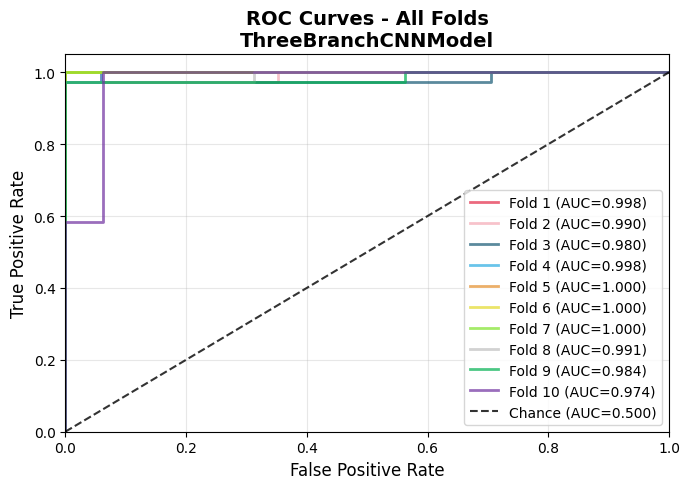

In [120]:
# --------------------------------------------------------------------------------
# 8. PLOTTING - ROC CURVES
# --------------------------------------------------------------------------------

from sklearn.metrics import auc
if len(fpr_list_all_folds) > 0 and len(tpr_list_all_folds) > 0:
    plt.figure(figsize=(7, 5))

    # Custom color palette
    colors = [
        "#E32947",  # red
        "#F4A9B5",  # pink
        "#155874",  # dark blue
        "#29ABE2",  # light blue
        "#E38D29",  # orange
        "#E3DA29",  # yellow
        "#7FE329",  # green (flashy)
        "#BFBFBF",  # grey
        "#00B050",  # green (basic)
        "#7030A0",  # purple
        "#996633",  # brown
    ]

    # Repeat colors if more folds than colors
    while len(colors) < len(fpr_list_all_folds):
        colors += colors

    # Plot ROC curve for each fold
    for i in range(len(fpr_list_all_folds)):
        if len(fpr_list_all_folds[i]) > 1 and len(tpr_list_all_folds[i]) > 1:
            # Calculate AUC for this fold
            fold_auc = auc(fpr_list_all_folds[i], tpr_list_all_folds[i])

            plt.plot(
                fpr_list_all_folds[i],
                tpr_list_all_folds[i],
                color=colors[i],
                alpha=0.7,
                linewidth=2,
                label=f'Fold {i+1} (AUC={fold_auc:.3f})'
            )

    # Plot chance line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.8, label='Chance (AUC=0.500)')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - All Folds\nThreeBranchCNNModel', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

else:
    print("No ROC data available for plotting")

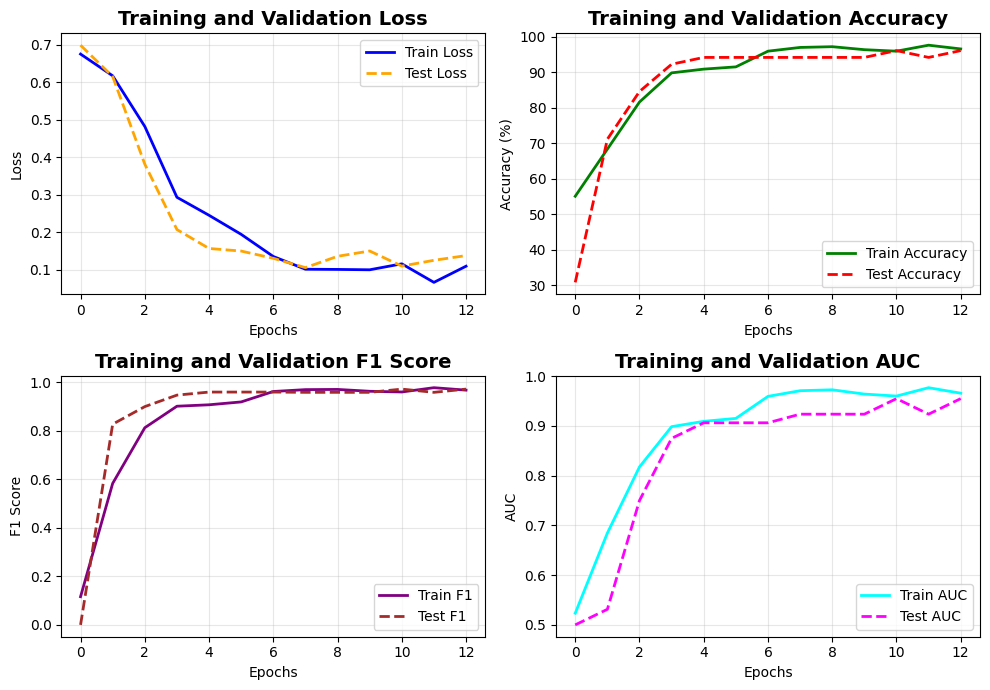


Last Fold Final Metrics:
Final Train Loss: 0.1097
Final Test Loss: 0.1379
Final Train Accuracy: 96.62%
Final Test Accuracy: 96.15%
Final Train F1: 0.9680
Final Test F1: 0.9722


In [121]:
# --------------------------------------------------------------------------------
# 9. PLOTTING - LEARNING CURVES
# --------------------------------------------------------------------------------

# Plot learning curves for the last fold
if len(train_loss_single_fold) > 0:
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    # 1. Loss curves
    axs[0, 0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
    axs[0, 0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
    axs[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy curves
    axs[0, 1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
    axs[0, 1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
    axs[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # 3. F1 Score curves
    axs[1, 0].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
    axs[1, 0].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
    axs[1, 0].set_title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # 4. AUC curves (if available)
    if len(auc_score_list_single_fold_train) > 0 and len(auc_score_list_single_fold) > 0:
        axs[1, 1].plot(auc_score_list_single_fold_train, label='Train AUC', color='cyan', linewidth=2)
        axs[1, 1].plot(auc_score_list_single_fold, label='Test AUC', color='magenta', linestyle='--', linewidth=2)
        axs[1, 1].set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('AUC')
        axs[1, 1].legend()
        axs[1, 1].grid(True, alpha=0.3)
    else:
        # If no AUC data, plot sensitivity/specificity
        if len(sensitivity_list_single_fold_train) > 0 and len(sensitivity_list_single_fold) > 0:
            axs[1, 1].plot(sensitivity_list_single_fold_train, label='Train Sensitivity', color='teal', linewidth=2)
            axs[1, 1].plot(sensitivity_list_single_fold, label='Test Sensitivity', color='coral', linestyle='--', linewidth=2)
            axs[1, 1].plot(specificity_list_single_fold_train, label='Train Specificity', color='navy', linewidth=2)
            axs[1, 1].plot(specificity_list_single_fold, label='Test Specificity', color='darkred', linestyle='--', linewidth=2)
            axs[1, 1].set_title('Training and Validation Sensitivity/Specificity', fontsize=14, fontweight='bold')
            axs[1, 1].set_xlabel('Epochs')
            axs[1, 1].set_ylabel('Score')
            axs[1, 1].legend()
            axs[1, 1].grid(True, alpha=0.3)
        else:
            axs[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print final values for the last fold
    print(f"\nLast Fold Final Metrics:")
    print(f"Final Train Loss: {train_loss_single_fold[-1]:.4f}")
    print(f"Final Test Loss: {test_loss_single_fold[-1]:.4f}")
    print(f"Final Train Accuracy: {accuracy_list_single_fold_train[-1]:.2f}%")
    print(f"Final Test Accuracy: {accuracy_list_single_fold[-1]:.2f}%")
    print(f"Final Train F1: {f1_list_single_fold_train[-1]:.4f}")
    print(f"Final Test F1: {f1_list_single_fold[-1]:.4f}")

else:
    print("No training data available for learning curves")

In [122]:
# --------------------------------------------------------------------------------
# 10. COMPREHENSIVE RESULTS SUMMARY
# --------------------------------------------------------------------------------

if len(f1_list_all_folds) > 0:
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*70)

    # Create a summary table
    summary_data = {
        'Metric': ['Accuracy', 'F1-Score', 'Sensitivity', 'Specificity', 'AUC'],
        'Mean Train': [
            f"{np.mean(accuracy_list_all_folds_train):.2f}%",
            f"{np.mean(f1_list_all_folds_train):.4f}",
            f"{np.mean(sensitivity_list_all_folds_train):.4f}",
            f"{np.mean(specificity_list_all_folds_train):.4f}",
            f"{np.mean(auc_score_list_all_folds_train):.4f}"
        ],
        'Std Train': [
            f"{np.std(accuracy_list_all_folds_train):.2f}%",
            f"{np.std(f1_list_all_folds_train):.4f}",
            f"{np.std(sensitivity_list_all_folds_train):.4f}",
            f"{np.std(specificity_list_all_folds_train):.4f}",
            f"{np.std(auc_score_list_all_folds_train):.4f}"
        ],
        'Mean Test': [
            f"{np.mean(accuracy_list_all_folds):.2f}%",
            f"{np.mean(f1_list_all_folds):.4f}",
            f"{np.mean(sensitivity_list_all_folds):.4f}",
            f"{np.mean(specificity_list_all_folds):.4f}",
            f"{np.mean(auc_score_list_all_folds):.4f}"
        ],
        'Std Test': [
            f"{np.std(accuracy_list_all_folds):.2f}%",
            f"{np.std(f1_list_all_folds):.4f}",
            f"{np.std(sensitivity_list_all_folds):.4f}",
            f"{np.std(specificity_list_all_folds):.4f}",
            f"{np.std(auc_score_list_all_folds):.4f}"
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary (10-Fold Cross Validation):")
    print(summary_df.to_string(index=False))

    # Print best and worst performing folds
    best_fold_idx = np.argmax(f1_list_all_folds)
    worst_fold_idx = np.argmin(f1_list_all_folds)

    print(f"\nBest Performing Fold: {best_fold_idx + 1}")
    print(f"  F1-Score: {f1_list_all_folds[best_fold_idx]:.4f}")
    print(f"  Accuracy: {accuracy_list_all_folds[best_fold_idx]:.2f}%")
    print(f"  AUC: {auc_score_list_all_folds[best_fold_idx]:.4f}")

    print(f"\nWorst Performing Fold: {worst_fold_idx + 1}")
    print(f"  F1-Score: {f1_list_all_folds[worst_fold_idx]:.4f}")
    print(f"  Accuracy: {accuracy_list_all_folds[worst_fold_idx]:.2f}%")
    print(f"  AUC: {auc_score_list_all_folds[worst_fold_idx]:.4f}")

    # Calculate performance gap (overfitting indicator)
    train_test_gap = abs(np.mean(f1_list_all_folds_train) - np.mean(f1_list_all_folds))
    print(f"\nTrain-Test Performance Gap (F1-Score): {train_test_gap:.4f}")
    if train_test_gap > 0.1:
        print("  ⚠️  Potential overfitting detected")
    elif train_test_gap < 0.05:
        print("  ✅ Good generalization")
    else:
        print("  ⚠️  Moderate generalization")

else:
    print("No comprehensive results available")


COMPREHENSIVE PERFORMANCE SUMMARY

Performance Summary (10-Fold Cross Validation):
     Metric Mean Train Std Train Mean Test Std Test
   Accuracy     95.82%     1.91%    98.29%    1.03%
   F1-Score     0.9591    0.0189    0.9875   0.0075
Sensitivity     0.9640    0.0208    0.9861   0.0139
Specificity     0.9522    0.0218    0.9761   0.0293
        AUC     0.9581    0.0190    0.9811   0.0135

Best Performing Fold: 6
  F1-Score: 1.0000
  Accuracy: 100.00%
  AUC: 1.0000

Worst Performing Fold: 10
  F1-Score: 0.9722
  Accuracy: 96.15%
  AUC: 0.9549

Train-Test Performance Gap (F1-Score): 0.0283
  ✅ Good generalization


# 2. Simple1DCNN

In [102]:
# --------------------------------------------------------------------------------
# SIMPLE 1D CNN MODEL (SOLO ECG PROCESADO)
# --------------------------------------------------------------------------------

class Simple1DCNN(nn.Module):
    def __init__(self, num_leads=12):
        super(Simple1DCNN, self).__init__()

        # Input: [Batch, 12, 5000]

        # --- BLOCCO 1: 12 -> 32 ---
        self.conv1 = nn.Conv1d(num_leads, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2) # Output: 2500

        # --- BLOCCO 2: 32 -> 64 ---
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2) # Output: 1250

        # --- BLOCCO 3: 64 -> 128 ---
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2) # Output: 625

        # --- BLOCCO 4: 128 -> 256 ---
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(2) # Output: 312

        # --- BLOCCO 5: 256 -> 256 ---
        self.conv5 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool1d(2) # Output: 156

        # --- BLOCCO 6: 256 -> 512 ---
        self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.act6 = nn.ReLU()
        self.pool6 = nn.MaxPool1d(2) # Output: 78

        # --- BLOCCO 7 (Extra Pooling): Solo riduzione dimensionale ---
        self.pool7 = nn.MaxPool1d(2) # Output: 39 punti

        # --- CLASSIFICATORE ---
        self.fc1 = nn.Linear(512 * 39, 128)
        self.act_fc = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Passaggio attraverso i 6 blocchi conv
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = self.pool3(self.act3(self.bn3(self.conv3(x))))
        x = self.pool4(self.act4(self.bn4(self.conv4(x))))
        x = self.pool5(self.act5(self.bn5(self.conv5(x))))
        x = self.pool6(self.act6(self.bn6(self.conv6(x))))

        # 7° Pooling extra
        x = self.pool7(x)

        # Flatten: [Batch, 512, 39] -> [Batch, 19968]
        x = x.view(x.size(0), -1)

        x = self.act_fc(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

# --------------------------------------------------------------------------------
# PREPROCESAR TODAS LAS SEÑALES ECG
# --------------------------------------------------------------------------------

def preprocess_all_ecg_signals(raw_signals):
    """
    Preprocess all ECG signals: bandpass filter + notch filter + z-score normalization
    """
    print("Preprocessing all ECG signals...")
    processed_signals = np.empty_like(raw_signals)

    for i in tqdm(range(len(raw_signals))):
        ecg = raw_signals[i].copy()

        # Apply filtering to each lead
        for j in range(ecg.shape[1]):
            # Bandpass filter
            ecg[:, j] = apply_bandpass_filter(ecg[:, j])
            # Notch filter
            ecg[:, j] = notch_filter(ecg[:, j])

        # Z-score normalization
        ecg = preprocess_signal(ecg)
        processed_signals[i] = ecg

    print(f"ECG preprocessing completed. Shape: {processed_signals.shape}")
    return processed_signals

# Preprocess all ECG signals
ecg_processed_signals = preprocess_all_ecg_signals(raw_signals)

# --------------------------------------------------------------------------------
# DATASET CLASS FOR SIMPLE 1D CNN (SOLO ECG PROCESADO)
# --------------------------------------------------------------------------------

class ProcessedECGDataset(Dataset):
    def __init__(self, processed_signals, labels):
        # Processed signals: (N, 5000, 12) -> transponer a (N, 12, 5000)
        self.processed_signals = torch.tensor(processed_signals, dtype=torch.float32).permute(0, 2, 1)

        # Labels (sport_ability)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.processed_signals[idx], self.labels[idx]

Preprocessing all ECG signals...


100%|██████████| 526/526 [00:20<00:00, 25.66it/s]

ECG preprocessing completed. Shape: (526, 5000, 12)


In [103]:
# --------------------------------------------------------------------------------
# 6. MAIN TRAINING LOOP WITH 10-FOLD CROSS VALIDATION (SIMPLE 1D CNN - ECG PROCESADO)
# --------------------------------------------------------------------------------

# Initialize results storage
f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
fpr_list_all_folds = []
tpr_list_all_folds = []

# Para learning curves completas
train_loss_curves = []
test_loss_curves = []
f1_train_curves = []
f1_test_curves = []

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 50

for fold, (train_index, test_index) in enumerate(strat_kf.split(tabular_data, tabular_data['sport_ability'])):
    print(f"\n{'='*50}")
    print(f"Training Fold {fold + 1}/10 - Simple1DCNN (ECG Processed)")
    print(f"{'='*50}")

    # Split data - usar solo sport_ability como label
    Y_train = tabular_data.iloc[train_index]['sport_ability']
    Y_test = tabular_data.iloc[test_index]['sport_ability']

    # Usar señales ECG preprocesadas
    ecg_train = ecg_processed_signals[train_index,:,:]
    ecg_test = ecg_processed_signals[test_index,:,:]

    # Create datasets (solo ECG procesado + sport_ability)
    train_dataset = ProcessedECGDataset(ecg_train, Y_train)
    test_dataset = ProcessedECGDataset(ecg_test, Y_test)

    # Handle class imbalance
    targets = Y_train.values.astype(int)
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    samples_weights = class_weights[targets]

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).double(),
        num_samples=len(samples_weights),
        replacement=True
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize SIMPLE 1D CNN model
    model = Simple1DCNN(num_leads=12).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Early stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    # Per-fold metrics
    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []
        all_train_outputs = []

        for ecg_batch, labels_batch in train_loader:
            ecg_batch = ecg_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(ecg_batch)  # Solo ECG procesado como entrada
            loss = criterion(outputs.squeeze(), labels_batch.squeeze())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).int()
            all_train_labels.extend(labels_batch.cpu())
            all_train_preds.extend(predicted.cpu())
            all_train_outputs.extend(outputs.cpu())

        avg_train_loss = train_loss / len(train_loader)
        train_loss_single_fold.append(avg_train_loss)

        # Calculate training metrics
        if len(all_train_labels) > 0:
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=0)
            cm = confusion_matrix(all_train_labels, all_train_preds)
            if cm.size == 1:
                train_sensitivity = 0.0
                train_specificity = 0.0
            else:
                tn, fp, fn, tp = cm.ravel()
                train_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                train_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            train_auc = roc_auc_score(all_train_labels, all_train_preds)
        else:
            train_accuracy = 0.0
            train_f1 = 0.0
            train_sensitivity = 0.0
            train_specificity = 0.0
            train_auc = 0.0

        # Testing phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []
        all_test_outputs = []
        all_test_probabilities = []

        with torch.no_grad():
            for ecg_batch, labels_batch in test_loader:
                ecg_batch = ecg_batch.to(device)
                labels_batch = labels_batch.to(device)

                outputs = model(ecg_batch)  # Solo ECG procesado como entrada
                loss = criterion(outputs.squeeze(), labels_batch.squeeze())
                test_loss += loss.item()

                predicted = (outputs.squeeze() > 0.5).int()
                probabilities = outputs.squeeze().cpu().numpy()

                all_test_labels.extend(labels_batch.cpu())
                all_test_preds.extend(predicted.cpu())
                all_test_outputs.extend(outputs.squeeze().cpu())
                all_test_probabilities.extend(probabilities)

        avg_test_loss = test_loss / len(test_loader)
        test_loss_single_fold.append(avg_test_loss)

        # Calculate test metrics
        if len(all_test_labels) > 0:
            test_accuracy = accuracy_score(all_test_labels, all_test_preds) * 100
            test_f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
            cm = confusion_matrix(all_test_labels, all_test_preds)
            if cm.size == 1:
                test_sensitivity = 0.0
                test_specificity = 0.0
            else:
                tn, fp, fn, tp = cm.ravel()
                test_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                test_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            test_auc = roc_auc_score(all_test_labels, all_test_preds)
        else:
            test_accuracy = 0.0
            test_f1 = 0.0
            test_sensitivity = 0.0
            test_specificity = 0.0
            test_auc = 0.0

        # Calculate ROC curve for this epoch
        if len(all_test_labels) > 0 and len(np.unique(all_test_labels)) > 1:
            fpr, tpr, _ = roc_curve(all_test_labels, all_test_probabilities)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
        else:
            fpr_list_single_fold.append(np.array([0, 1]))
            tpr_list_single_fold.append(np.array([0, 1]))

        # Store metrics
        f1_list_single_fold.append(test_f1)
        f1_list_single_fold_train.append(train_f1)
        sensitivity_list_single_fold.append(test_sensitivity)
        sensitivity_list_single_fold_train.append(train_sensitivity)
        specificity_list_single_fold.append(test_specificity)
        specificity_list_single_fold_train.append(train_specificity)
        accuracy_list_single_fold.append(test_accuracy)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold.append(test_auc)
        auc_score_list_single_fold_train.append(train_auc)
        epochs_single_fold.append(epoch)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
            print(f"Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
            print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")

        # Early stopping check
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            trigger_times = 0
            torch.save(model.state_dict(), f'best_model_simple1d_processed_fold_{fold}.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                model.load_state_dict(torch.load(f'best_model_simple1d_processed_fold_{fold}.pth'))
                break

    # Store best epoch results for this fold (FUERA del loop de epochs)
    if len(f1_list_single_fold) > 0 and len(fpr_list_single_fold) > 0:
        best_epoch_idx = np.argmax(f1_list_single_fold)

        if best_epoch_idx < len(fpr_list_single_fold) and best_epoch_idx < len(tpr_list_single_fold):
            # Guardar FPR/TPR para ROC
            fpr_list_all_folds.append(fpr_list_single_fold[best_epoch_idx])
            tpr_list_all_folds.append(tpr_list_single_fold[best_epoch_idx])

            # Guardar otras métricas del mejor epoch
            f1_list_all_folds.append(f1_list_single_fold[best_epoch_idx])
            f1_list_all_folds_train.append(f1_list_single_fold_train[best_epoch_idx])
            sensitivity_list_all_folds.append(sensitivity_list_single_fold[best_epoch_idx])
            sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[best_epoch_idx])
            specificity_list_all_folds.append(specificity_list_single_fold[best_epoch_idx])
            specificity_list_all_folds_train.append(specificity_list_single_fold_train[best_epoch_idx])
            accuracy_list_all_folds.append(accuracy_list_single_fold[best_epoch_idx])
            accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[best_epoch_idx])
            auc_score_list_all_folds.append(auc_score_list_single_fold[best_epoch_idx])
            auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[best_epoch_idx])
            test_loss_all_folds.append(test_loss_single_fold[best_epoch_idx])
            train_loss_all_folds.append(train_loss_single_fold[best_epoch_idx])
            epochs_all_fold.append(epochs_single_fold[best_epoch_idx])

            # Guardar curvas completas para learning curves
            train_loss_curves.append(train_loss_single_fold.copy())
            test_loss_curves.append(test_loss_single_fold.copy())
            f1_train_curves.append(f1_list_single_fold_train.copy())
            f1_test_curves.append(f1_list_single_fold.copy())

            print(f"\nFold {fold + 1} Completed - Best Test F1: {f1_list_all_folds[-1]:.4f}")
        else:
            print(f"\nFold {fold + 1} - Index out of range for ROC data")
    else:
        print(f"\nFold {fold + 1} - No metrics or ROC data available")


Training Fold 1/10 - Simple1DCNN (ECG Processed)


 10%|█         | 5/50 [02:23<20:15, 27.01s/it]


Epoch 5/50
Train Loss: 0.6136, Test Loss: 0.5965
Train Acc: 66.81%, Test Acc: 77.36%
Train F1: 0.6963, Test F1: 0.8421


 20%|██        | 10/50 [04:35<17:42, 26.57s/it]


Epoch 10/50
Train Loss: 0.4098, Test Loss: 0.8983
Train Acc: 81.61%, Test Acc: 64.15%
Train F1: 0.8121, Test F1: 0.7077


 20%|██        | 10/50 [05:00<20:03, 30.09s/it]

Early stopping triggered at epoch 11!

Fold 1 Completed - Best Test F1: 0.8642

Training Fold 2/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:07<18:55, 25.24s/it]


Epoch 5/50
Train Loss: 0.5805, Test Loss: 0.5953
Train Acc: 69.13%, Test Acc: 69.81%
Train F1: 0.6880, Test F1: 0.7949


 18%|█▊        | 9/50 [04:14<19:19, 28.28s/it]


Epoch 10/50
Train Loss: 0.4391, Test Loss: 0.7039
Train Acc: 77.59%, Test Acc: 60.38%
Train F1: 0.7452, Test F1: 0.6769
Early stopping triggered at epoch 10!

Fold 2 Completed - Best Test F1: 0.8140

Training Fold 3/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:06<18:55, 25.23s/it]


Epoch 5/50
Train Loss: 0.6340, Test Loss: 0.6946
Train Acc: 61.52%, Test Acc: 67.92%
Train F1: 0.6389, Test F1: 0.7733


 20%|██        | 10/50 [04:11<16:45, 25.13s/it]


Epoch 10/50
Train Loss: 0.5616, Test Loss: 0.7122
Train Acc: 69.13%, Test Acc: 69.81%
Train F1: 0.7316, Test F1: 0.7949


 20%|██        | 10/50 [04:36<18:26, 27.67s/it]

Early stopping triggered at epoch 11!

Fold 3 Completed - Best Test F1: 0.8250

Training Fold 4/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:07<19:04, 25.43s/it]


Epoch 5/50
Train Loss: 0.5238, Test Loss: 0.5597
Train Acc: 71.88%, Test Acc: 71.70%
Train F1: 0.7577, Test F1: 0.8000


 20%|██        | 10/50 [04:13<16:57, 25.43s/it]


Epoch 10/50
Train Loss: 0.4517, Test Loss: 0.6604
Train Acc: 78.86%, Test Acc: 60.38%
Train F1: 0.7934, Test F1: 0.6667


 22%|██▏       | 11/50 [05:04<18:01, 27.73s/it]

Early stopping triggered at epoch 12!

Fold 4 Completed - Best Test F1: 0.8169

Training Fold 5/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:07<19:17, 25.73s/it]


Epoch 5/50
Train Loss: 0.5775, Test Loss: 0.6085
Train Acc: 68.71%, Test Acc: 71.70%
Train F1: 0.6967, Test F1: 0.8101


 18%|█▊        | 9/50 [04:14<19:18, 28.25s/it]



Epoch 10/50
Train Loss: 0.3938, Test Loss: 0.7839
Train Acc: 82.24%, Test Acc: 62.26%
Train F1: 0.8174, Test F1: 0.6970
Early stopping triggered at epoch 10!

Fold 5 Completed - Best Test F1: 0.8148

Training Fold 6/10 - Simple1DCNN (ECG Processed)


 10%|█         | 5/50 [02:07<19:07, 25.51s/it]


Epoch 5/50
Train Loss: 0.6329, Test Loss: 0.7230
Train Acc: 64.27%, Test Acc: 58.49%
Train F1: 0.6998, Test F1: 0.6071


 20%|██        | 10/50 [04:17<17:22, 26.06s/it]


Epoch 10/50
Train Loss: 0.4874, Test Loss: 0.6361
Train Acc: 76.74%, Test Acc: 67.92%
Train F1: 0.7598, Test F1: 0.8046


 20%|██        | 10/50 [04:42<18:48, 28.21s/it]

Early stopping triggered at epoch 11!

Fold 6 Completed - Best Test F1: 0.8046

Training Fold 7/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:06<18:41, 24.92s/it]


Epoch 5/50
Train Loss: 0.5938, Test Loss: 0.6702
Train Acc: 66.67%, Test Acc: 50.00%
Train F1: 0.6667, Test F1: 0.5000


 12%|█▏        | 6/50 [02:58<21:45, 29.68s/it]

Early stopping triggered at epoch 7!

Fold 7 Completed - Best Test F1: 0.8276

Training Fold 8/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:03<18:29, 24.65s/it]


Epoch 5/50
Train Loss: 0.6187, Test Loss: 0.5999
Train Acc: 64.35%, Test Acc: 67.31%
Train F1: 0.5185, Test F1: 0.7463


 20%|██        | 10/50 [04:09<16:46, 25.17s/it]


Epoch 10/50
Train Loss: 0.4788, Test Loss: 0.7833
Train Acc: 78.48%, Test Acc: 57.69%
Train F1: 0.7733, Test F1: 0.6071


 30%|███       | 15/50 [06:12<14:14, 24.42s/it]


Epoch 15/50
Train Loss: 0.3549, Test Loss: 0.7396
Train Acc: 83.12%, Test Acc: 61.54%
Train F1: 0.8291, Test F1: 0.6875


 30%|███       | 15/50 [06:37<15:27, 26.50s/it]

Early stopping triggered at epoch 16!

Fold 8 Completed - Best Test F1: 0.8684

Training Fold 9/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:06<18:51, 25.15s/it]


Epoch 5/50
Train Loss: 0.5686, Test Loss: 0.9544
Train Acc: 68.99%, Test Acc: 44.23%
Train F1: 0.6682, Test F1: 0.4727


 10%|█         | 5/50 [02:30<22:34, 30.10s/it]

Early stopping triggered at epoch 6!

Fold 9 Completed - Best Test F1: 0.7848

Training Fold 10/10 - Simple1DCNN (ECG Processed)



 10%|█         | 5/50 [02:05<18:46, 25.02s/it]


Epoch 5/50
Train Loss: 0.5862, Test Loss: 0.7099
Train Acc: 69.62%, Test Acc: 50.00%
Train F1: 0.6962, Test F1: 0.5806


 12%|█▏        | 6/50 [02:55<21:29, 29.31s/it]

Early stopping triggered at epoch 7!

Fold 10 Completed - Best Test F1: 0.7945


In [104]:
# --------------------------------------------------------------------------------
# 7. FINAL RESULTS - SIMPLE 1D CNN (ECG PROCESADO)
# --------------------------------------------------------------------------------

print("\n" + "="*70)
print("FINAL 10-FOLD CROSS VALIDATION RESULTS - Simple1DCNN (ECG Processed)")
print("="*70)

if len(accuracy_list_all_folds) > 0:
    print(f"\nTest Accuracy: {accuracy_list_all_folds}")
    print(f"Mean Test Accuracy: {np.mean(accuracy_list_all_folds):.2f}% ± {np.std(accuracy_list_all_folds):.2f}%")

    print(f"\nTrain Accuracy: {accuracy_list_all_folds_train}")
    print(f"Mean Train Accuracy: {np.mean(accuracy_list_all_folds_train):.2f}% ± {np.std(accuracy_list_all_folds_train):.2f}%")

    print(f"\nTest F1 Score: {f1_list_all_folds}")
    print(f"Mean Test F1: {np.mean(f1_list_all_folds):.4f} ± {np.std(f1_list_all_folds):.4f}")

    print(f"\nTrain F1 Score: {f1_list_all_folds_train}")
    print(f"Mean Train F1: {np.mean(f1_list_all_folds_train):.4f} ± {np.std(f1_list_all_folds_train):.4f}")

    print(f"\nTest Sensitivity: {sensitivity_list_all_folds}")
    print(f"Mean Test Sensitivity: {np.mean(sensitivity_list_all_folds):.4f} ± {np.std(sensitivity_list_all_folds):.4f}")

    print(f"\nTest Specificity: {specificity_list_all_folds}")
    print(f"Mean Test Specificity: {np.mean(specificity_list_all_folds):.4f} ± {np.std(specificity_list_all_folds):.4f}")

    print(f"\nTest AUC: {auc_score_list_all_folds}")
    print(f"Mean Test AUC: {np.mean(auc_score_list_all_folds):.4f} ± {np.std(auc_score_list_all_folds):.4f}")

    # Performance summary
    print(f"\nPerformance Summary:")
    print(f"Best Fold F1: {np.max(f1_list_all_folds):.4f} (Fold {np.argmax(f1_list_all_folds) + 1})")
    print(f"Worst Fold F1: {np.min(f1_list_all_folds):.4f} (Fold {np.argmin(f1_list_all_folds) + 1})")
    print(f"Model Stability (F1 std): {np.std(f1_list_all_folds):.4f}")

else:
    print("No successful folds to report results")


FINAL 10-FOLD CROSS VALIDATION RESULTS - Simple1DCNN (ECG Processed)

Test Accuracy: [79.24528301886792, 69.81132075471697, 73.58490566037736, 75.47169811320755, 71.69811320754717, 67.9245283018868, 71.15384615384616, 80.76923076923077, 67.3076923076923, 71.15384615384616]
Mean Test Accuracy: 72.81% ± 4.27%

Train Accuracy: [74.63002114164905, 52.21987315010571, 69.3446088794926, 74.63002114164905, 68.71035940803382, 76.74418604651163, 53.16455696202531, 71.94092827004219, 55.27426160337553, 68.35443037974683]
Mean Train Accuracy: 66.50% ± 8.89%

Test F1 Score: [0.8641975308641975, 0.813953488372093, 0.825, 0.8169014084507042, 0.8148148148148148, 0.8045977011494253, 0.8275862068965517, 0.868421052631579, 0.7848101265822784, 0.7945205479452054]
Mean Test F1: 0.8215 ± 0.0256

Train F1 Score: [0.7142857142857143, 0.5170940170940171, 0.7487001733102253, 0.7489539748953975, 0.7120622568093385, 0.759825327510917, 0.5506072874493927, 0.6997742663656885, 0.49282296650717705, 0.690082644628099

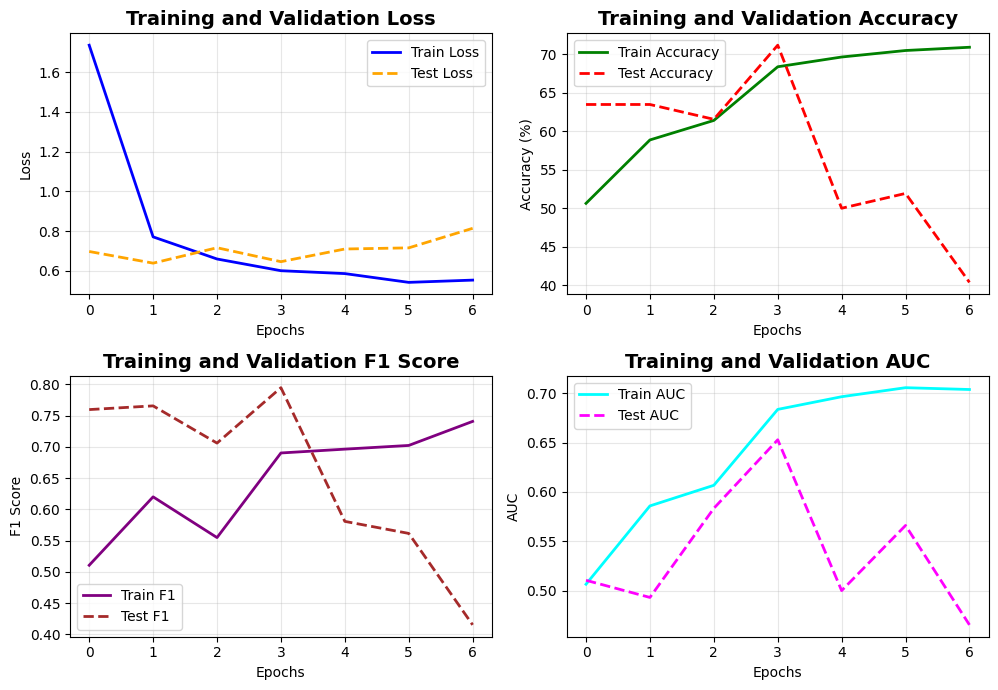


Last Fold Final Metrics:
Final Train Loss: 0.5534
Final Test Loss: 0.8139
Final Train Accuracy: 70.89%
Final Test Accuracy: 40.38%
Final Train F1: 0.7406
Final Test F1: 0.4151


In [105]:
# --------------------------------------------------------------------------------
# 9. PLOTTING - LEARNING CURVES
# --------------------------------------------------------------------------------

# Plot learning curves for the last fold
if len(train_loss_single_fold) > 0:
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    # 1. Loss curves
    axs[0, 0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
    axs[0, 0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
    axs[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy curves
    axs[0, 1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
    axs[0, 1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
    axs[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # 3. F1 Score curves
    axs[1, 0].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
    axs[1, 0].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
    axs[1, 0].set_title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # 4. AUC curves (if available)
    if len(auc_score_list_single_fold_train) > 0 and len(auc_score_list_single_fold) > 0:
        axs[1, 1].plot(auc_score_list_single_fold_train, label='Train AUC', color='cyan', linewidth=2)
        axs[1, 1].plot(auc_score_list_single_fold, label='Test AUC', color='magenta', linestyle='--', linewidth=2)
        axs[1, 1].set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('AUC')
        axs[1, 1].legend()
        axs[1, 1].grid(True, alpha=0.3)
    else:
        # If no AUC data, plot sensitivity/specificity
        if len(sensitivity_list_single_fold_train) > 0 and len(sensitivity_list_single_fold) > 0:
            axs[1, 1].plot(sensitivity_list_single_fold_train, label='Train Sensitivity', color='teal', linewidth=2)
            axs[1, 1].plot(sensitivity_list_single_fold, label='Test Sensitivity', color='coral', linestyle='--', linewidth=2)
            axs[1, 1].plot(specificity_list_single_fold_train, label='Train Specificity', color='navy', linewidth=2)
            axs[1, 1].plot(specificity_list_single_fold, label='Test Specificity', color='darkred', linestyle='--', linewidth=2)
            axs[1, 1].set_title('Training and Validation Sensitivity/Specificity', fontsize=14, fontweight='bold')
            axs[1, 1].set_xlabel('Epochs')
            axs[1, 1].set_ylabel('Score')
            axs[1, 1].legend()
            axs[1, 1].grid(True, alpha=0.3)
        else:
            axs[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print final values for the last fold
    print(f"\nLast Fold Final Metrics:")
    print(f"Final Train Loss: {train_loss_single_fold[-1]:.4f}")
    print(f"Final Test Loss: {test_loss_single_fold[-1]:.4f}")
    print(f"Final Train Accuracy: {accuracy_list_single_fold_train[-1]:.2f}%")
    print(f"Final Test Accuracy: {accuracy_list_single_fold[-1]:.2f}%")
    print(f"Final Train F1: {f1_list_single_fold_train[-1]:.4f}")
    print(f"Final Test F1: {f1_list_single_fold[-1]:.4f}")

else:
    print("No training data available for learning curves")

In [110]:
# --------------------------------------------------------------------------------
# 10. COMPREHENSIVE RESULTS SUMMARY
# --------------------------------------------------------------------------------

if len(f1_list_all_folds) > 0:
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*70)

    # Create a summary table
    summary_data = {
        'Metric': ['Accuracy', 'F1-Score', 'Sensitivity', 'Specificity', 'AUC'],
        'Mean Train': [
            f"{np.mean(accuracy_list_all_folds_train):.2f}%",
            f"{np.mean(f1_list_all_folds_train):.4f}",
            f"{np.mean(sensitivity_list_all_folds_train):.4f}",
            f"{np.mean(specificity_list_all_folds_train):.4f}",
            f"{np.mean(auc_score_list_all_folds_train):.4f}"
        ],
        'Std Train': [
            f"{np.std(accuracy_list_all_folds_train):.2f}%",
            f"{np.std(f1_list_all_folds_train):.4f}",
            f"{np.std(sensitivity_list_all_folds_train):.4f}",
            f"{np.std(specificity_list_all_folds_train):.4f}",
            f"{np.std(auc_score_list_all_folds_train):.4f}"
        ],
        'Mean Test': [
            f"{np.mean(accuracy_list_all_folds):.2f}%",
            f"{np.mean(f1_list_all_folds):.4f}",
            f"{np.mean(sensitivity_list_all_folds):.4f}",
            f"{np.mean(specificity_list_all_folds):.4f}",
            f"{np.mean(auc_score_list_all_folds):.4f}"
        ],
        'Std Test': [
            f"{np.std(accuracy_list_all_folds):.2f}%",
            f"{np.std(f1_list_all_folds):.4f}",
            f"{np.std(sensitivity_list_all_folds):.4f}",
            f"{np.std(specificity_list_all_folds):.4f}",
            f"{np.std(auc_score_list_all_folds):.4f}"
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary (10-Fold Cross Validation):")
    print(summary_df.to_string(index=False))

    # Print best and worst performing folds
    best_fold_idx = np.argmax(f1_list_all_folds)
    worst_fold_idx = np.argmin(f1_list_all_folds)

    print(f"\nBest Performing Fold: {best_fold_idx + 1}")
    print(f"  F1-Score: {f1_list_all_folds[best_fold_idx]:.4f}")
    print(f"  Accuracy: {accuracy_list_all_folds[best_fold_idx]:.2f}%")
    print(f"  AUC: {auc_score_list_all_folds[best_fold_idx]:.4f}")

    print(f"\nWorst Performing Fold: {worst_fold_idx + 1}")
    print(f"  F1-Score: {f1_list_all_folds[worst_fold_idx]:.4f}")
    print(f"  Accuracy: {accuracy_list_all_folds[worst_fold_idx]:.2f}%")
    print(f"  AUC: {auc_score_list_all_folds[worst_fold_idx]:.4f}")

    # Calculate performance gap (overfitting indicator)
    train_test_gap = abs(np.mean(f1_list_all_folds_train) - np.mean(f1_list_all_folds))
    print(f"\nTrain-Test Performance Gap (F1-Score): {train_test_gap:.4f}")
    if train_test_gap > 0.1:
        print("  ⚠️  Potential overfitting detected")
    elif train_test_gap < 0.05:
        print("  ✅ Good generalization")
    else:
        print("  ⚠️  Moderate generalization")

else:
    print("No comprehensive results available")


COMPREHENSIVE PERFORMANCE SUMMARY

Performance Summary (10-Fold Cross Validation):
     Metric Mean Train Std Train Mean Test Std Test
   Accuracy     66.50%     8.89%    72.81%    4.27%
   F1-Score     0.6634    0.0970    0.8215   0.0256
Sensitivity     0.6757    0.1214    0.9139   0.0663
Specificity     0.6508    0.1149    0.3257   0.1971
        AUC     0.6632    0.0893    0.6198   0.0780

Best Performing Fold: 8
  F1-Score: 0.8684
  Accuracy: 80.77%
  AUC: 0.7396

Worst Performing Fold: 9
  F1-Score: 0.7848
  Accuracy: 67.31%
  AUC: 0.5556

Train-Test Performance Gap (F1-Score): 0.1581
  ⚠️  Potential overfitting detected


In [93]:
def plot_preprocessing_pipeline(ecg_signal, tabular_data, patient_idx=0, lead_idx=0):
    """
    Visualize the complete preprocessing pipeline for a single ECG signal and tabular data
    """

    # Create a comprehensive figure
    fig = plt.figure(figsize=(20, 16))

    # ============================================================================
    # 1. RAW ECG SIGNAL
    # ============================================================================
    ax1 = plt.subplot(3, 4, 1)
    time_axis = np.arange(ecg_signal.shape[0]) / FS
    plt.plot(time_axis, ecg_signal[:, lead_idx], 'b-', linewidth=1)
    plt.title('1. Raw ECG Signal\n(Lead {})'.format(lead_idx + 1), fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True, alpha=0.3)

    # ============================================================================
    # 2. BANDPASS FILTERED (1-40 Hz)
    # ============================================================================
    ax2 = plt.subplot(3, 4, 2)
    ecg_bandpass = ecg_signal.copy()
    for i in range(ecg_bandpass.shape[1]):
        ecg_bandpass[:, i] = apply_bandpass_filter(ecg_bandpass[:, i])

    plt.plot(time_axis, ecg_bandpass[:, lead_idx], 'g-', linewidth=1)
    plt.title('2. Bandpass Filtered\n(1-40 Hz)', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True, alpha=0.3)

    # ============================================================================
    # 3. NOTCH FILTERED (50 Hz)
    # ============================================================================
    ax3 = plt.subplot(3, 4, 3)
    ecg_notch = ecg_bandpass.copy()
    for i in range(ecg_notch.shape[1]):
        ecg_notch[:, i] = notch_filter(ecg_notch[:, i])

    plt.plot(time_axis, ecg_notch[:, lead_idx], 'r-', linewidth=1)
    plt.title('3. Notch Filtered\n(50 Hz removed)', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True, alpha=0.3)

    # ============================================================================
    # 4. Z-SCORE NORMALIZED
    # ============================================================================
    ax4 = plt.subplot(3, 4, 4)
    ecg_normalized = preprocess_signal(ecg_notch)

    plt.plot(time_axis, ecg_normalized[:, lead_idx], 'purple', linewidth=1)
    plt.title('4. Z-Score Normalized\n(Per lead)', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True, alpha=0.3)

    # ============================================================================
    # 5. R-PEAK DETECTION
    # ============================================================================
    ax5 = plt.subplot(3, 4, 5)
    lead_for_detection = ecg_notch[:, LEAD_II_INDEX]

    # R-peak detection process
    diff_signal = np.diff(lead_for_detection)**2
    window_size = int(0.150 * FS)
    integrated_signal = np.convolve(diff_signal, np.ones(window_size)/window_size, mode='same')

    distance_min = int(0.3 * FS)
    peak_threshold = np.max(integrated_signal) * 0.4
    r_peaks_idx, _ = find_peaks(integrated_signal, height=peak_threshold, distance=distance_min)

    # Plot ECG with detected R-peaks
    time_detection = np.arange(len(lead_for_detection)) / FS
    plt.plot(time_detection, lead_for_detection, 'b-', linewidth=1, alpha=0.7, label='ECG Signal')
    plt.plot(r_peaks_idx/FS, lead_for_detection[r_peaks_idx], 'ro',
             markersize=6, label='Detected R-peaks')
    plt.title('5. R-Peak Detection\n(Lead II for detection)', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ============================================================================
    # 6. BEAT SEGMENTATION
    # ============================================================================
    ax6 = plt.subplot(3, 4, 6)

    all_beats = []
    half_beat = BEAT_LENGTH_SAMPLES // 2

    for r_idx in r_peaks_idx:
        start_idx = r_idx - half_beat
        end_idx = r_idx + half_beat
        if start_idx >= 0 and end_idx <= ecg_notch.shape[0]:
            beat = ecg_notch[start_idx:end_idx, lead_idx]
            all_beats.append(beat)

    # Plot segmented beats
    if all_beats:
        beat_time = np.arange(BEAT_LENGTH_SAMPLES) / FS
        for i, beat in enumerate(all_beats[:5]):  # Show first 5 beats
            plt.plot(beat_time, beat, alpha=0.7, linewidth=1,
                    label=f'Beat {i+1}' if i < 3 else "")

        plt.title('6. Beat Segmentation\n(Individual beats)', fontweight='bold')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        if len(all_beats) <= 3:
            plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No beats detected',
                ha='center', va='center', transform=ax6.transAxes)
        plt.title('6. Beat Segmentation\n(No beats)', fontweight='bold')

    # ============================================================================
    # 7. AVERAGE BEAT MORPHOLOGY
    # ============================================================================
    ax7 = plt.subplot(3, 4, 7)

    if all_beats:
        segmented_ecg = np.array(all_beats, dtype=np.float32)
        representative_ecg = np.mean(segmented_ecg, axis=0)

        plt.plot(beat_time, representative_ecg, 'purple', linewidth=2, label='Average Beat')
        plt.fill_between(beat_time,
                        representative_ecg - np.std(segmented_ecg, axis=0),
                        representative_ecg + np.std(segmented_ecg, axis=0),
                        alpha=0.3, color='purple', label='±1 std')

        plt.title('7. Average Beat Morphology\n(Representative beat)', fontweight='bold')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No average beat\n(no beats detected)',
                ha='center', va='center', transform=ax7.transAxes)
        plt.title('7. Average Beat Morphology\n(No data)', fontweight='bold')

    # ============================================================================
    # 8. SPECTROGRAM
    # ============================================================================
    ax8 = plt.subplot(3, 4, 8)

    try:
        f, t, Sxx = spectrogram(ecg_normalized[:, lead_idx], FS, nperseg=256)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
        plt.title('8. Spectrogram\n(Frequency content)', fontweight='bold')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar(label='Power (dB)')
        plt.ylim(0, 50)  # Focus on relevant frequencies
    except:
        plt.text(0.5, 0.5, 'Spectrogram\ncalculation failed',
                ha='center', va='center', transform=ax8.transAxes)
        plt.title('8. Spectrogram\n(Error)', fontweight='bold')

    # ============================================================================
    # 9. ALL 12 LEADS - RAW
    # ============================================================================
    ax9 = plt.subplot(3, 4, 9)

    for i in range(min(12, ecg_signal.shape[1])):
        offset = i * 2  # Vertical offset for each lead
        plt.plot(time_axis, ecg_signal[:, i] + offset, linewidth=0.8,
                label=f'Lead {i+1}' if i < 3 else "")

    plt.title('9. All 12 Leads - Raw', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Leads (offset)')
    if ecg_signal.shape[1] <= 3:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yticks([])

    # ============================================================================
    # 10. ALL 12 LEADS - PROCESSED
    # ============================================================================
    ax10 = plt.subplot(3, 4, 10)

    for i in range(min(12, ecg_normalized.shape[1])):
        offset = i * 3  # Vertical offset for each lead
        plt.plot(time_axis, ecg_normalized[:, i] + offset, linewidth=0.8,
                label=f'Lead {i+1}' if i < 3 else "")

    plt.title('10. All 12 Leads - Processed', fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Leads (offset)')
    if ecg_normalized.shape[1] <= 3:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yticks([])

    # ============================================================================
    # 11. TABULAR DATA - ORIGINAL
    # ============================================================================
    ax11 = plt.subplot(3, 4, 11)

    if isinstance(tabular_data, pd.DataFrame) and patient_idx < len(tabular_data):
        patient_data = tabular_data.iloc[patient_idx]

        # Select available features for visualization
        possible_features = ['age_at_exam', 'weight', 'height', 'trainning_load', 'sport_ability',
                           'BMI', 'BSA', 'sex', 'sport_classification']
        available_features = [f for f in possible_features if f in patient_data.index]

        if available_features:
            values = patient_data[available_features].values
            feature_names = available_features

            bars = plt.bar(range(len(feature_names)), values,
                          color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet', 'orange', 'pink'])
            plt.title('11. Tabular Data - Original', fontweight='bold')
            plt.xlabel('Features')
            plt.ylabel('Values')
            plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
            plt.grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.1f}', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(0.5, 0.5, 'No tabular features\navailable for display',
                    ha='center', va='center', transform=ax11.transAxes)
            plt.title('11. Tabular Data - Original\n(No features)', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'No tabular data\navailable',
                ha='center', va='center', transform=ax11.transAxes)
        plt.title('11. Tabular Data - Original\n(No data)', fontweight='bold')

    # ============================================================================
    # 12. TABULAR DATA - PROCESSED
    # ============================================================================
    ax12 = plt.subplot(3, 4, 12)

    if isinstance(tabular_data, pd.DataFrame) and patient_idx < len(tabular_data):
        try:
            # Use the already processed data (tabular_data_processed should have BMI, BSA)
            processed_patient = tabular_data.iloc[patient_idx]

            # Show available processed features
            processed_features_available = ['BMI', 'BSA', 'age_at_exam', 'weight', 'trainning_load']
            available_processed = [f for f in processed_features_available if f in processed_patient.index]

            if available_processed:
                values = processed_patient[available_processed].values

                plt.bar(range(len(available_processed)), values,
                       color='orange', alpha=0.7)
                plt.title('12. Tabular Data - Processed', fontweight='bold')
                plt.xlabel('Processed Features')
                plt.ylabel('Values')
                plt.xticks(range(len(available_processed)), available_processed, rotation=45, ha='right')
                plt.grid(True, alpha=0.3, axis='y')
            else:
                plt.text(0.5, 0.5, 'No processed features\navailable',
                        ha='center', va='center', transform=ax12.transAxes)
                plt.title('12. Tabular Data - Processed\n(No features)', fontweight='bold')

        except Exception as e:
            plt.text(0.5, 0.5, f'Processing Error:\n{str(e)[:50]}...',
                    ha='center', va='center', transform=ax12.transAxes)
            plt.title('12. Tabular Data - Processed\n(Error)', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'No tabular data\navailable',
                ha='center', va='center', transform=ax12.transAxes)
        plt.title('12. Tabular Data - Processed\n(No data)', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*80)
    print("PREPROCESSING PIPELINE SUMMARY")
    print("="*80)

    print(f"\nECG Signal Analysis:")
    print(f"  - Signal duration: {ecg_signal.shape[0]/FS:.2f} seconds")
    print(f"  - Number of leads: {ecg_signal.shape[1]}")
    print(f"  - R-peaks detected: {len(r_peaks_idx)}")
    print(f"  - Beats segmented: {len(all_beats)}")

    if all_beats:
        print(f"  - Beat duration: {BEAT_LENGTH_SAMPLES/FS:.2f} seconds")
        print(f"  - Heart rate: {len(r_peaks_idx) / (ecg_signal.shape[0]/FS) * 60:.1f} BPM")

    print(f"\nSignal Statistics (Lead {lead_idx + 1}):")
    print(f"  - Raw signal - Mean: {np.mean(ecg_signal[:, lead_idx]):.2f}, Std: {np.std(ecg_signal[:, lead_idx]):.2f}")
    print(f"  - Processed signal - Mean: {np.mean(ecg_normalized[:, lead_idx]):.2f}, Std: {np.std(ecg_normalized[:, lead_idx]):.2f}")

    if isinstance(tabular_data, pd.DataFrame) and patient_idx < len(tabular_data):
        print(f"\nTabular Data Summary:")
        patient_data = tabular_data.iloc[patient_idx]

        # Show available features
        available_info = []
        if 'sport_ability' in patient_data:
            sport_status = "Positive" if patient_data['sport_ability'] == 1 else "Negative"
            available_info.append(f"Sport ability: {sport_status}")
        if 'age_at_exam' in patient_data:
            available_info.append(f"Age: {patient_data['age_at_exam']:.1f} years")
        if 'BMI' in patient_data:
            available_info.append(f"BMI: {patient_data['BMI']:.1f}")
        if 'weight' in patient_data:
            available_info.append(f"Weight: {patient_data['weight']:.1f} kg")

        for info in available_info:
            print(f"  - {info}")

        if not available_info:
            print(f"  - No tabular information available")

Loading sample data for visualization...

Visualizing Patient 1
ECG Signal Shape: (5000, 12)
Focusing on Lead 1
Available columns in tabular data: ['ECG_patient_id', 'age_at_exam', 'sex', 'weight', 'trainning_load', 'sport_classification', 'sport_ability', 'AV block', 'ST abnormality', 'Complete BBB', 'Prolonged QTc', 'Uncontrolled hypertension', 'Supraventricular arrhythmias', 'Ventricular arrhythmias', 'Baseline ECG abnormalities', 'Valvular heart diseases', 'Symptomatic patients', 'BMI', 'BSA']


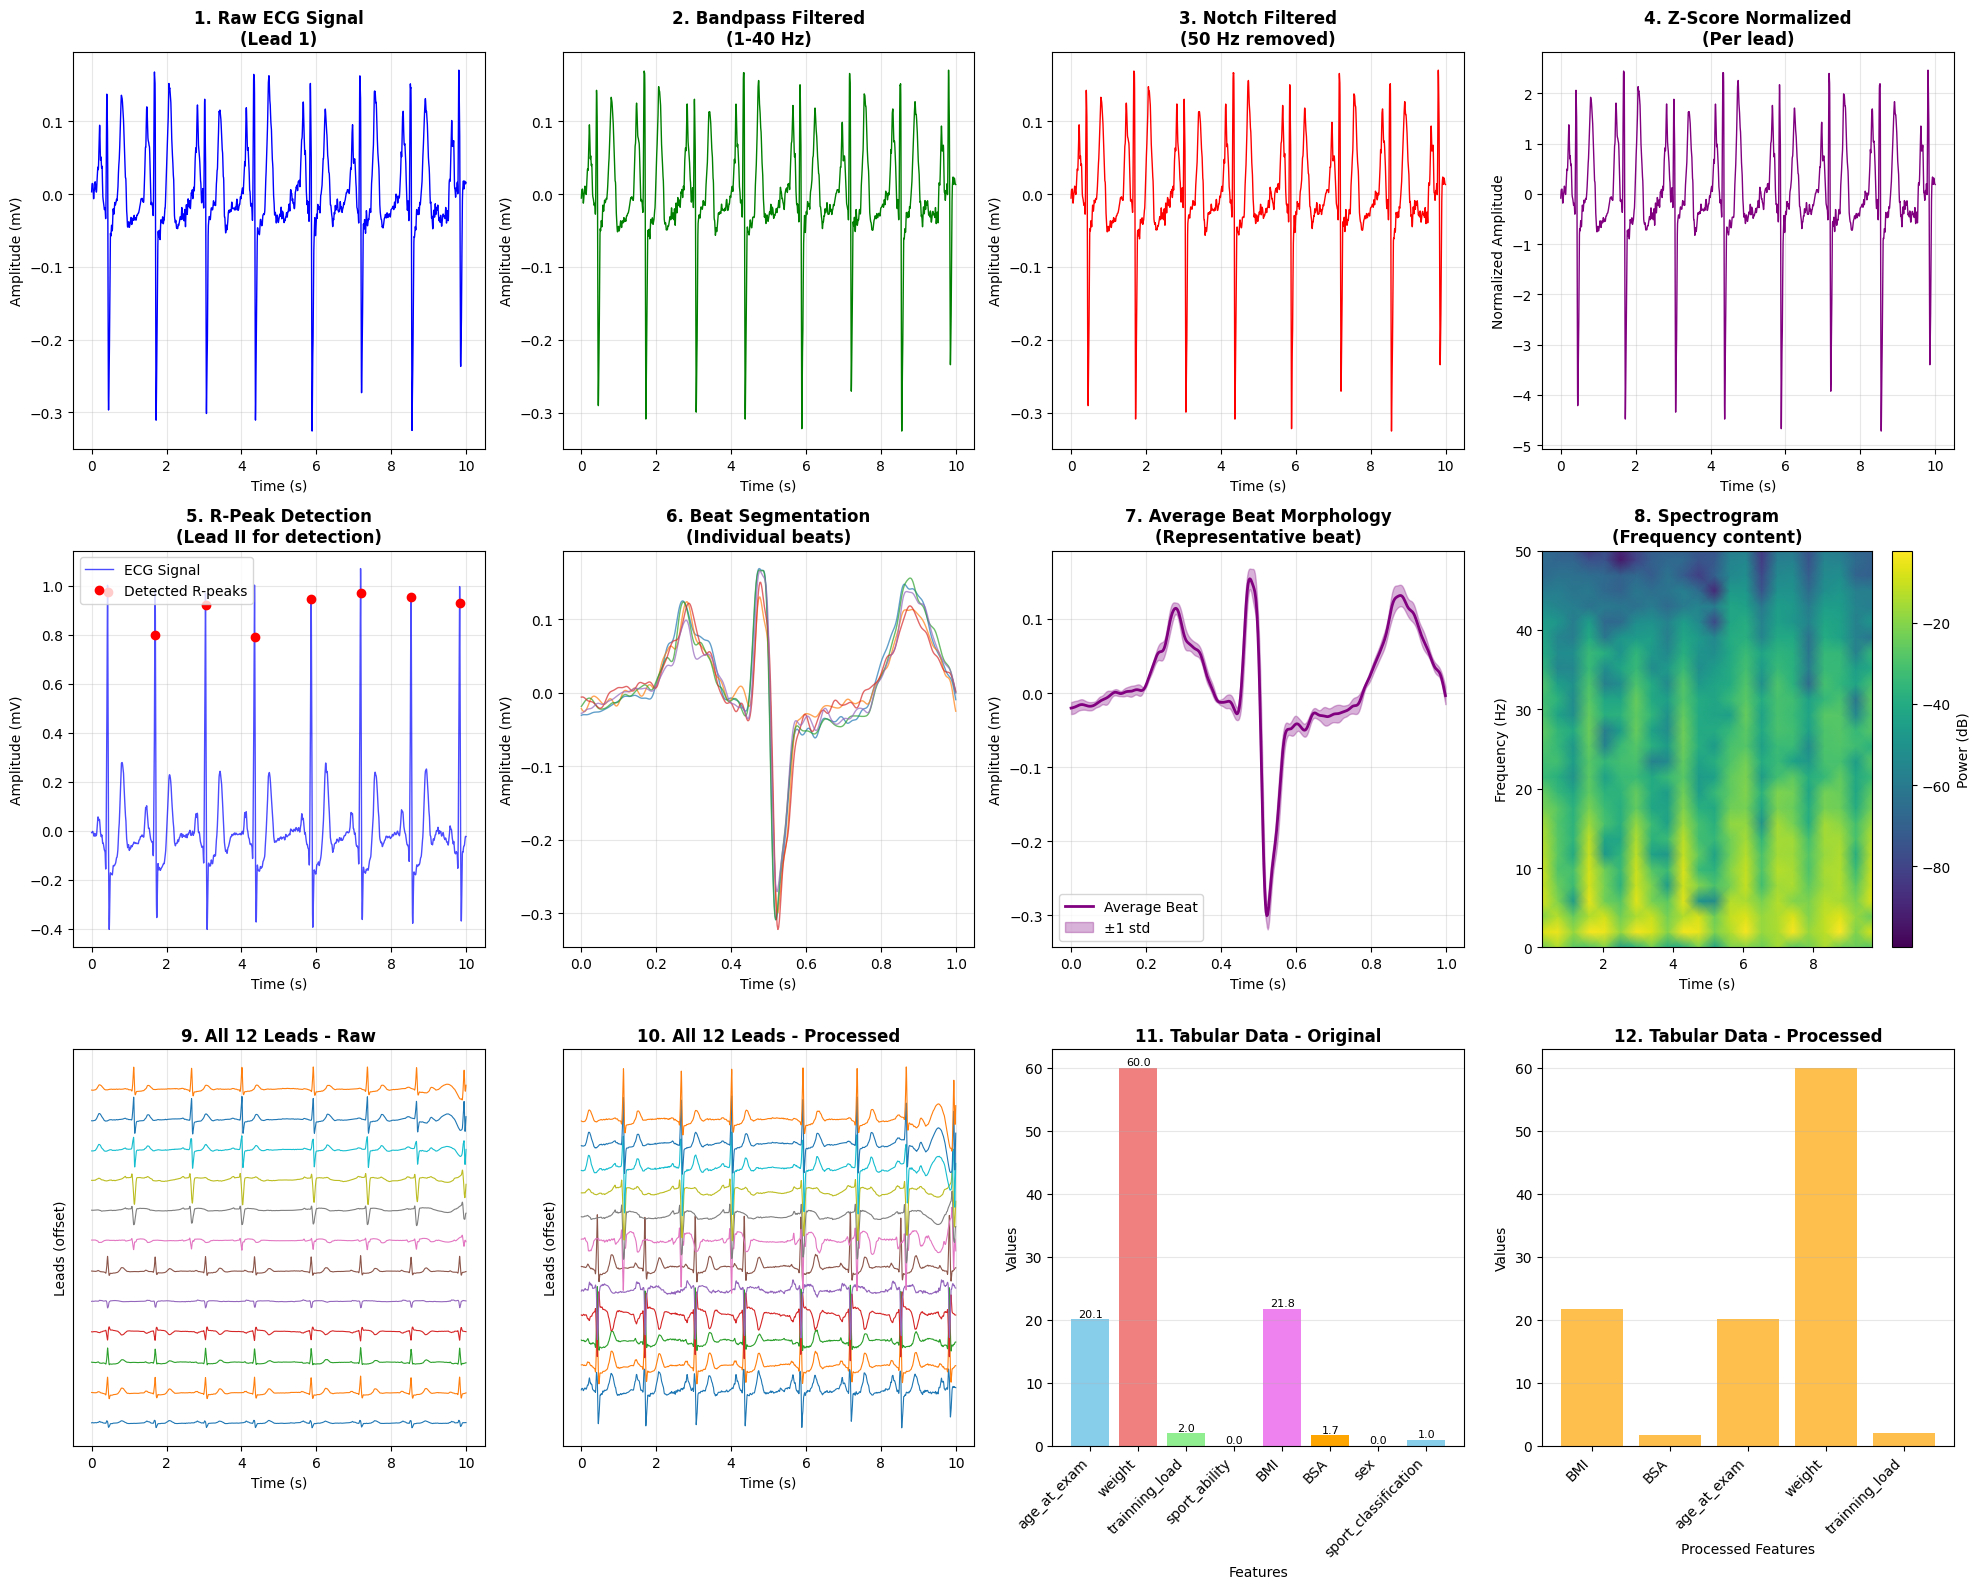


PREPROCESSING PIPELINE SUMMARY

ECG Signal Analysis:
  - Signal duration: 10.00 seconds
  - Number of leads: 12
  - R-peaks detected: 8
  - Beats segmented: 6
  - Beat duration: 1.00 seconds
  - Heart rate: 48.0 BPM

Signal Statistics (Lead 1):
  - Raw signal - Mean: 0.00, Std: 0.07
  - Processed signal - Mean: 0.00, Std: 1.00

Tabular Data Summary:
  - Sport ability: Negative
  - Age: 20.1 years
  - BMI: 21.8
  - Weight: 60.0 kg


In [94]:
# Select a sample patient for visualization
sample_patient_idx = 0  # Change this to see different patients
sample_lead_idx = 0     # Lead to focus on (0-11)

print("Loading sample data for visualization...")

# Get a sample ECG signal
if len(raw_signals) > sample_patient_idx:
    sample_ecg = raw_signals[sample_patient_idx]

    print(f"\nVisualizing Patient {sample_patient_idx + 1}")
    print(f"ECG Signal Shape: {sample_ecg.shape}")
    print(f"Focusing on Lead {sample_lead_idx + 1}")

    # Debug: Check available columns in tabular data
    print(f"Available columns in tabular data: {list(tabular_data_processed.columns)}")

    # Run the complete visualization pipeline
    plot_preprocessing_pipeline(sample_ecg, tabular_data_processed,
                               patient_idx=sample_patient_idx,
                               lead_idx=sample_lead_idx)
else:
    print("No ECG data available for visualization")

In [95]:
# --------------------------------------------------------------------------------
# ADDITIONAL: COMPARE MULTIPLE PATIENTS
# --------------------------------------------------------------------------------

def compare_patients(patient_indices=[0, 1, 2], lead_idx=0):
    """Compare preprocessing results across multiple patients"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, patient_idx in enumerate(patient_indices):
        if patient_idx >= len(raw_signals):
            continue

        # Get and process ECG
        ecg_raw = raw_signals[patient_idx]
        ecg_processed = ecg_raw.copy()

        # Apply preprocessing pipeline
        for j in range(ecg_processed.shape[1]):
            ecg_processed[:, j] = apply_bandpass_filter(ecg_processed[:, j])
            ecg_processed[:, j] = notch_filter(ecg_processed[:, j])
        ecg_processed = preprocess_signal(ecg_processed)

        # Plot raw vs processed
        time_axis = np.arange(ecg_raw.shape[0]) / FS

        axes[i*2].plot(time_axis, ecg_raw[:, lead_idx], 'b-', alpha=0.7, linewidth=1)
        axes[i*2].set_title(f'Patient {patient_idx+1} - Raw', fontweight='bold')
        axes[i*2].set_xlabel('Time (s)')
        axes[i*2].set_ylabel('Amplitude')
        axes[i*2].grid(True, alpha=0.3)

        axes[i*2+1].plot(time_axis, ecg_processed[:, lead_idx], 'r-', alpha=0.7, linewidth=1)
        axes[i*2+1].set_title(f'Patient {patient_idx+1} - Processed', fontweight='bold')
        axes[i*2+1].set_xlabel('Time (s)')
        axes[i*2+1].set_ylabel('Normalized')
        axes[i*2+1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Comparing multiple patients...


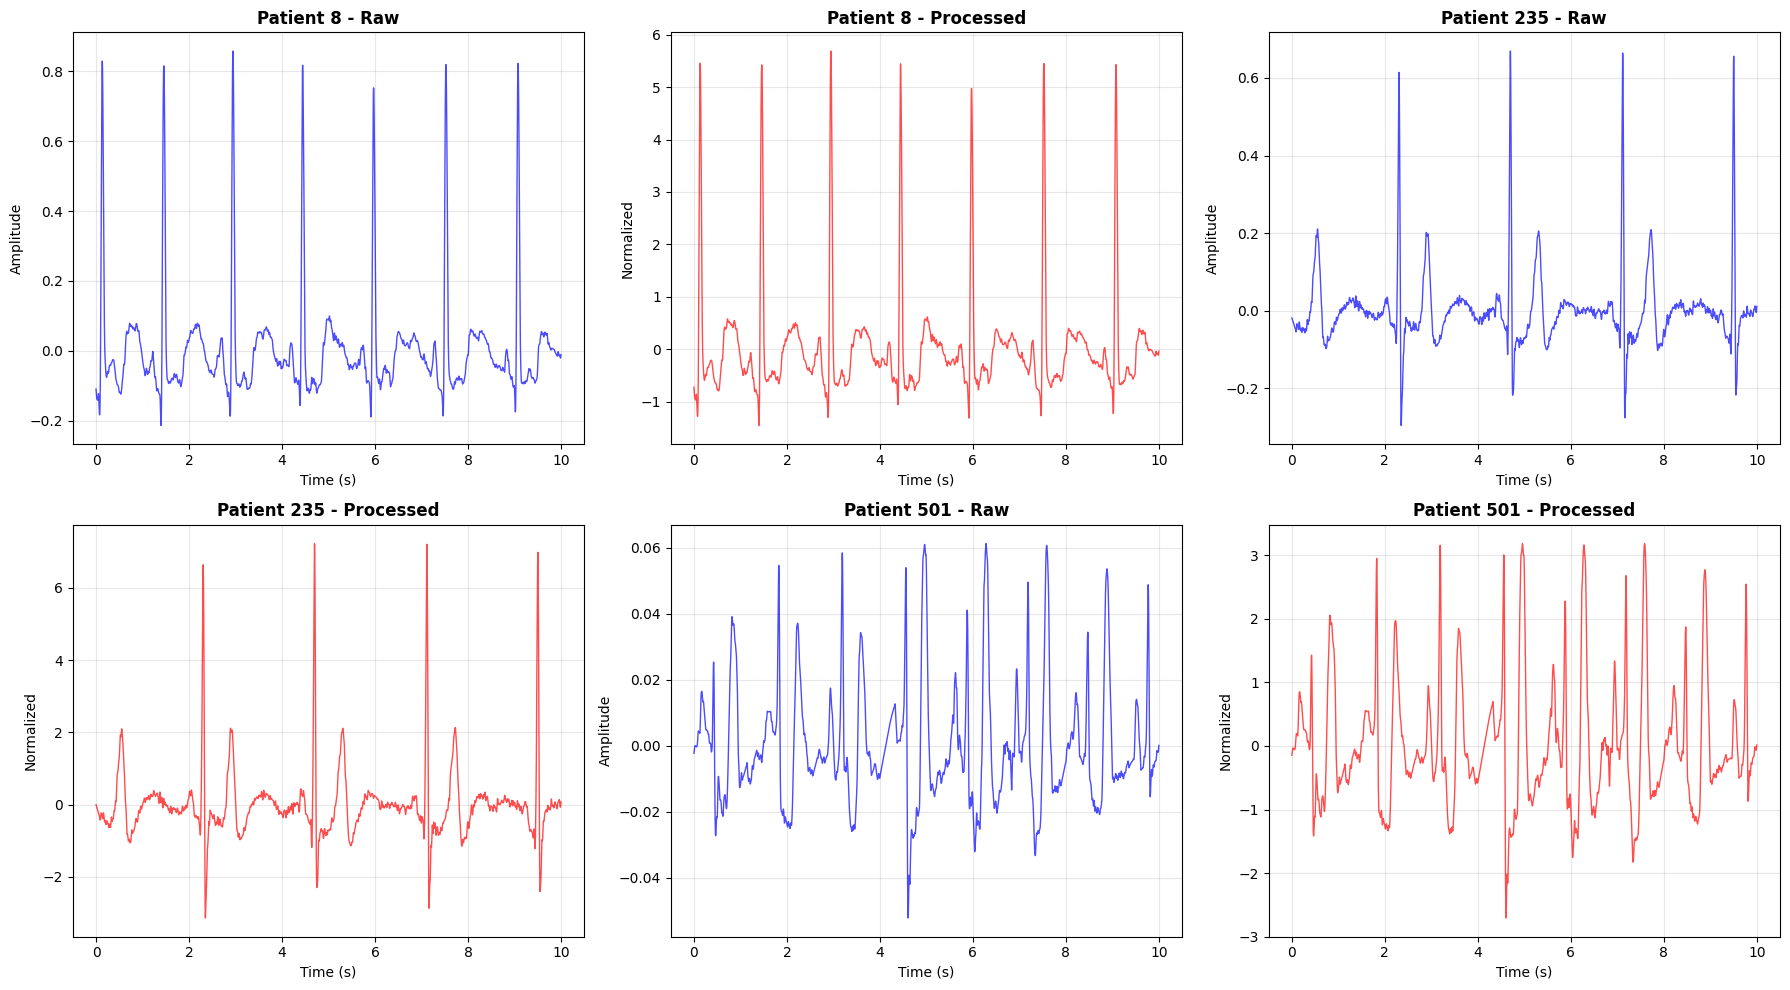

In [97]:
# Uncomment to compare multiple patients
print("\nComparing multiple patients...")
compare_patients(patient_indices=[7, 234, 500], lead_idx=0)